# Objective
    
    Back order prediction.
    
# Features
    
    Sku (Categorical)	 Random ID for the product
    national_inv 	     Current inventory level for the part
    lead_time 	         Transit time for product (if available)
    in_transit_qty	     Amount of product in transit from source
    forecast_3_month 	 Forecast sales for the next 3 months
    forecast_6_month 	 Forecast sales for the next 6 months
    forecast_9_month 	 Forecast sales for the next 9 months
    sales_1_month 	     Sales quantity for the prior 1 month time period
    sales_3_month 	     Sales quantity for the prior 3 month time period
    sales_6_month 	     Sales quantity for the prior 6 month time period
    sales_9_month 	     Sales quantity for the prior 9 month time period
    min_bank 	         Minimum recommend amount to stock
    potential_issue 	 Source issue for part identified
    pieces_past_due 	 Parts overdue from source
    perf_6_month_avg 	 Source performance for prior 6 month period
    perf_12_month_avg  	 Source performance for prior 12 month period
    local_bo_qty 	     Amount of stock orders overdue
    deck_risk            Whether the product is vulnerable to deck (transit) based risks.
    oe_constraint        General part risk flag
    ppap_risk            Whether the product is vulnerable to production quality based risks.
    stop_auto_buy        Whether the product has automated stock warning system.
    rev_stop             General part risk flag
    went_on_backorder    Product actually went on backorder. This is the target value.


# Importing required libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.stats import ttest_ind,mannwhitneyu,chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

# Reading the data

In [2]:
df1 = pd.read_csv('Kaggle_Training_Dataset_v2.csv',low_memory=False)
df2 = pd.read_csv('Kaggle_Test_Dataset_v2.csv',low_memory=False)

In [3]:
df1.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [4]:
df1.shape,df2.shape

((1687861, 23), (242076, 23))

The train data contains 1687861 rows and 242076 rows in test data. Both the datasets have 23 columns each.

# Checking the 5 point statistical summary of train data

In [6]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.111782,29615.233831,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.872267,7.056024,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.052022,1342.741731,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.119284,5026.553102,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.986664,9795.151861,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.364431,14378.923562,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.926069,1928.195879,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.025930,5192.377625,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.728839,9613.167104,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.269701,14838.613523,0.0,0.00,4.00,47.00,3205172.0


# Checking the 5 point statistical summary of test data

In [7]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,242075.0,499.751028,29280.390793,-25414.0,4.00,15.00,81.00,12145792.0
lead_time,227351.0,7.923018,7.041410,0.0,4.00,8.00,9.00,52.0
in_transit_qty,242075.0,36.178213,898.673127,0.0,0.00,0.00,0.00,265272.0
forecast_3_month,242075.0,181.472345,5648.874620,0.0,0.00,0.00,4.00,1510592.0
forecast_6_month,242075.0,348.807304,10081.797119,0.0,0.00,0.00,12.00,2157024.0
forecast_9_month,242075.0,508.296301,14109.723787,0.0,0.00,0.00,20.00,3162260.0
sales_1_month,242075.0,51.478195,1544.678350,0.0,0.00,0.00,4.00,349620.0
sales_3_month,242075.0,172.139316,5164.243624,0.0,0.00,1.00,14.00,1099852.0
sales_6_month,242075.0,340.425414,9386.523492,0.0,0.00,2.00,30.00,2103389.0
sales_9_month,242075.0,511.775446,13976.702192,0.0,0.00,4.00,46.00,3195211.0


**Performance is between 0 and 1, but we see that negative values are present in the dataset**

In [6]:
df1[df1['perf_6_month_avg']<0]['perf_6_month_avg'].value_counts()

-99.0    129478
Name: perf_6_month_avg, dtype: int64

In [7]:
df1[df1['perf_12_month_avg']<0]['perf_12_month_avg'].value_counts()

-99.0    122050
Name: perf_12_month_avg, dtype: int64

perf_6_month_avg, perf_12_month_avg variables have negative values. Hence replacing them with nulls first and then applying the null value treatment.

In [4]:
df1['perf_6_month_avg'] = df1['perf_6_month_avg'].replace(-99,np.nan)
df1['perf_12_month_avg'] = df1['perf_12_month_avg'].replace(-99,np.nan)

df2['perf_6_month_avg'] = df2['perf_6_month_avg'].replace(-99,np.nan)
df2['perf_12_month_avg'] = df2['perf_12_month_avg'].replace(-99,np.nan)

# Checking percentage of null values 

In [11]:
print("Null values percentage in the train dataset: \n", (df1.isnull().sum())/(df1.shape[0])*100)
print("\n")
print("Null values percentage in the test dataset: \n",(df2.isnull().sum())/(df2.shape[0])*100)

Null values percentage in the train dataset: 
 sku                  0.000000
national_inv         0.000059
lead_time            5.977625
in_transit_qty       0.000059
forecast_3_month     0.000059
forecast_6_month     0.000059
forecast_9_month     0.000059
sales_1_month        0.000059
sales_3_month        0.000059
sales_6_month        0.000059
sales_9_month        0.000059
min_bank             0.000059
potential_issue      0.000059
pieces_past_due      0.000059
perf_6_month_avg     7.671189
perf_12_month_avg    7.231105
local_bo_qty         0.000059
deck_risk            0.000059
oe_constraint        0.000059
ppap_risk            0.000059
stop_auto_buy        0.000059
rev_stop             0.000059
went_on_backorder    0.000059
dtype: float64


Null values percentage in the test dataset: 
 sku                  0.000000
national_inv         0.000413
lead_time            6.082800
in_transit_qty       0.000413
forecast_3_month     0.000413
forecast_6_month     0.000413
forecast_9_month    

Null values are less than 8% of the total data. Hence dropping the nulls.

# Dropping the nulls

In [5]:
df1.dropna(inplace=True)

df2.dropna(inplace = True)

In [13]:
print("Null values in the train dataset: \n",df1.isnull().sum())
print("\n")
print("Null values in the test dataset: \n",df2.isnull().sum())

Null values in the train dataset: 
 sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


Null values in the test dataset: 
 sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty     

## Statistically comparing original test and train files.

In [14]:
for i in df1.select_dtypes(include=np.number):
    t1,p1 = jarque_bera(df1[i])
    t2,p2 = jarque_bera(df2[i])
    if p1<0.05 or p2<0.05:
        t3,p3 = mannwhitneyu(df1[i],df2[i])
        if p3<0.05:
            print('Mean',i,'is not same for df1 and df2')
        else:
            print('Mean',i,'is same for df1 and df2')
    else:
        t4,p4 = ttest_ind(df1[i],df2[i])
        if p4<0.05:
            print('Mean',i,'is not same for df1 and df2')
        else:
            print('Mean',i,'is same for df1 and df2')
        

Mean national_inv is not same for df1 and df2
Mean lead_time is not same for df1 and df2
Mean in_transit_qty is not same for df1 and df2
Mean forecast_3_month is not same for df1 and df2
Mean forecast_6_month is same for df1 and df2
Mean forecast_9_month is same for df1 and df2
Mean sales_1_month is not same for df1 and df2
Mean sales_3_month is not same for df1 and df2
Mean sales_6_month is same for df1 and df2
Mean sales_9_month is same for df1 and df2
Mean min_bank is same for df1 and df2
Mean pieces_past_due is not same for df1 and df2
Mean perf_6_month_avg is not same for df1 and df2
Mean perf_12_month_avg is not same for df1 and df2
Mean local_bo_qty is not same for df1 and df2


Since few of the columns do not have statistically equal mean for df1 and df2, we cannot say that they represent eachother. Hence we join them to a single dataset.

# Concatinating both the dataframes into a single dataframe

In [7]:
df = pd.concat([df1,df2],axis=0).reset_index(drop=True)

In [8]:
df.to_csv('kaggleinitail_concat.csv')

# Shape of the whole concatenated data

In [8]:
df.shape

(1781356, 23)

The final dataframe has 1781356 row and 23 columns including the traget variable.

# Checking for the target varibale proportion

In [9]:
df['went_on_backorder'].value_counts(normalize=True)*100

No     99.246248
Yes     0.753752
Name: went_on_backorder, dtype: float64

In [10]:
df['went_on_backorder'].value_counts()

No     1767929
Yes      13427
Name: went_on_backorder, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781356 entries, 0 to 1781355
Data columns (total 23 columns):
sku                  object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue      object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk            object
oe_constraint        object
ppap_risk            object
stop_auto_buy        object
rev_stop             object
went_on_backorder    object
dtypes: float64(15), object(8)
memory usage: 312.6+ MB


# Checking the duplicate records in the dataset if any

In [20]:
df[df.duplicated()]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder


# Dropping sku feature as it is an unique ID column and does not contribute to modeling

In [13]:
df.drop(columns='sku',inplace=True)

# Checking the 5 point statistical summary of final dataframe

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,1781356.0,378.984118,11250.912122,-27256.0,4.00,14.00,76.00,6363276.0
lead_time,1781356.0,7.783747,6.736117,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1781356.0,44.235561,1259.623325,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1781356.0,190.816173,5315.001737,0.0,0.00,0.00,6.00,1510592.0
forecast_6_month,1781356.0,368.979564,10226.775765,0.0,0.00,0.00,16.00,2461360.0
forecast_9_month,1781356.0,540.913775,14918.808039,0.0,0.00,0.00,26.00,3777304.0
sales_1_month,1781356.0,55.902779,1814.182547,0.0,0.00,0.00,5.00,741774.0
sales_3_month,1781356.0,176.628317,4962.906560,0.0,0.00,1.00,16.00,1105478.0
sales_6_month,1781356.0,349.037103,9619.017616,0.0,0.00,3.00,33.00,2146625.0
sales_9_month,1781356.0,537.452417,14981.301926,0.0,0.00,4.00,51.00,3205172.0


The five point summary for all the numerical features in the dataset is as above.

We see that the national inventory minimum is negative which can be possible sometimes. Hence not treating it.

## Statistical test for feature significance

checking the features which are significant in predicting the backorders

### 1. Numerical Features

In [23]:
from scipy.stats import ttest_ind,mannwhitneyu
from scipy.stats import jarque_bera

len(df.select_dtypes(include=np.number).columns)

sig_var=[]
for i in df.select_dtypes(include=np.number).columns:
    cat1 = df[df['went_on_backorder']=='Yes'][i]
    cat2 = df[df['went_on_backorder']=='No'][i]
    t1,p1 = jarque_bera(cat1)
    t2,p2 = jarque_bera(cat2)
    print('H0: The avg',i,' for went to back order yes = avg',i,'for went to back order no')
    print('H0: The avg',i,' for went to back order yes != avg',i,'for went to back order no')
    if p1 < 0.05 or p2 <0.05:
        print('\nThe data is not normally distributed for',i,'hence manwhitneyu test')
        print(mannwhitneyu(cat1,cat2))
        print('\n')
        t,p = mannwhitneyu(cat1,cat2)
        if p < 0.05:
            sig_var.append((str(i),p))
            
    else:
        print('\nThe data is normally distributed, hence ttest_ind')
        print(ttest_ind(cat1,cat2))
        print('\n')
        t,p = ttest_ind(cat1,cat2)
        if p < 0.05:
            sig_var.append((str(i),p))

H0: The avg national_inv  for went to back order yes = avg national_inv for went to back order no
H0: The avg national_inv  for went to back order yes != avg national_inv for went to back order no

The data is not normally distributed for national_inv hence manwhitneyu test
MannwhitneyuResult(statistic=4698966574.5, pvalue=0.0)


H0: The avg lead_time  for went to back order yes = avg lead_time for went to back order no
H0: The avg lead_time  for went to back order yes != avg lead_time for went to back order no

The data is not normally distributed for lead_time hence manwhitneyu test
MannwhitneyuResult(statistic=10236147353.0, pvalue=2.0084094676024828e-183)


H0: The avg in_transit_qty  for went to back order yes = avg in_transit_qty for went to back order no
H0: The avg in_transit_qty  for went to back order yes != avg in_transit_qty for went to back order no

The data is not normally distributed for in_transit_qty hence manwhitneyu test
MannwhitneyuResult(statistic=10750725023.5, p

**From the above test we can conclude that the significant variables are as follows**

In [24]:
pd.DataFrame(sig_var,columns=['Feature_name','P_value'])

,Feature_name,P_value
0,national_inv,0.000000e+00
1,lead_time,2.008409e-183
2,in_transit_qty,1.029293e-153
3,forecast_3_month,0.000000e+00
4,forecast_6_month,0.000000e+00
5,forecast_9_month,0.000000e+00
6,sales_1_month,0.000000e+00
7,sales_3_month,0.000000e+00
8,sales_6_month,0.000000e+00
9,sales_9_month,0.000000e+00


In [25]:
len(sig_var)

14

### 2. Categorical Features

In [26]:
c = []

from statsmodels.stats.proportion import proportions_ztest

In [27]:
print(list(df.select_dtypes(include='object').columns)) 

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [28]:
len(df.select_dtypes(include='object').columns)

7

**H0: Proportion potential_issue yes in went to back order No = Proportion of potential_issue ye in went to back order Yes**

**HA: Proportion potential_issue yes in went to back order No != Proportion of potential_issue ye in went to back order Yes**

In [29]:
 pd.crosstab(df['went_on_backorder'],df['potential_issue'])

potential_issue,No,Yes
went_on_backorder,,
No,1767022,907
Yes,13373,54


In [30]:
print(proportions_ztest([930,54],[1799815+930,13519+54]))

(-17.25899840639288, 9.575749538583128e-67)


In [31]:
c.append('potential_issue')

The pvalue < 0.05 hence we reject the H0, ie; the feature is significant.

**H0: Proportion deck_risk yes in went to back order No = Proportion of deck_risk ye in went to back order Yes**

**HA: Proportion deck_risk yes in went to back order No != Proportion of deck_risk ye in went to back order Yes**

In [32]:
pd.crosstab(df['went_on_backorder'],df['deck_risk'])

deck_risk,No,Yes
went_on_backorder,,
No,1418654,349275
Yes,11269,2158


In [33]:
print(proportions_ztest([358992,201],[1441753+358992,11372+2201]))

(53.75484199784722, 0.0)


In [34]:
c.append('deck_risk')

The pvalue < 0.05 hence we reject the H0, ie; the feature is significant.

**H0: Proportion oe_constraint yes in went to back order No = Proportion of oe_constraint ye in went to back order Yes**

**HA: Proportion oe_constraint yes in went to back order No != Proportion of oe_constraint ye in went to back order Yes**

In [35]:
 pd.crosstab(df['went_on_backorder'],df['oe_constraint'])

oe_constraint,No,Yes
went_on_backorder,,
No,1767646,283
Yes,13418,9


In [36]:
print(proportions_ztest([283,9],[1800462+283,13564+9]))

(-4.629059779045442, 3.673297271308511e-06)


In [37]:
c.append('oe_constraint')

The pvalue < 0.05 hence we reject the H0, ie; the feature is significant.

**H0: Proportion ppap_risk yes in went to back order No = Proportion of ppap_risk ye in went to back order Yes**

**HA: Proportion ppap_risk yes in went to back order No != Proportion of ppap_risk ye in went to back order Yes**

In [38]:
 pd.crosstab(df['went_on_backorder'],df['ppap_risk'])

ppap_risk,No,Yes
went_on_backorder,,
No,1561798,206131
Yes,11390,2037


In [39]:
print(proportions_ztest([213034,2049],[213034+1587711,2049+11524]))

(-11.726109002898433, 9.36662303636482e-32)


In [40]:
c.append('ppap_risk')

The pvalue < 0.05 hence we reject the H0, ie; the feature is significant.

**H0: Proportion stop_auto_buy yes in went to back order No = Proportion of stop_auto_buy ye in went to back order Yes**

**HA: Proportion stop_auto_buy yes in went to back order No != Proportion of stop_auto_buy ye in went to back order Yes**

In [41]:

pd.crosstab(df['went_on_backorder'],df['stop_auto_buy'])

stop_auto_buy,No,Yes
went_on_backorder,,
No,40791,1727138
Yes,382,13045


In [42]:
print(proportions_ztest([1755749,13177],[1755749+44996,13177+396]))

(3.1124096362702733, 0.0018556681378781555)


In [43]:
c.append('stop_auto_buy')

**H0: Proportion rev_stop yes in went to back order No = Proportion of rev_stop ye in went to back order Yes**

**HA: Proportion rev_stop yes in went to back order No != Proportion of rev_stop ye in went to back order Yes**

In [44]:
 pd.crosstab(df['went_on_backorder'],df['rev_stop'])

rev_stop,No,Yes
went_on_backorder,,
No,1767511,418
Yes,13423,4


In [45]:
proportions_ztest([466,4],[1800279+466,13569+4])

(-0.25907112812186095, 0.7955803608912853)

The pvalue >0.05 hence accept H0, ie; rev_stop is insignificant

In [46]:
print('The significant features of categorical nature are:',c)

The significant features of categorical nature are: ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy']


In [47]:
for i in sig_var:
    c.append(i[0])

In [48]:
print('The final list of significant features are:\n',pd.DataFrame(c))

The final list of significant features are:
                     0
0     potential_issue
1           deck_risk
2       oe_constraint
3           ppap_risk
4       stop_auto_buy
5        national_inv
6           lead_time
7      in_transit_qty
8    forecast_3_month
9    forecast_6_month
10   forecast_9_month
11      sales_1_month
12      sales_3_month
13      sales_6_month
14      sales_9_month
15    pieces_past_due
16   perf_6_month_avg
17  perf_12_month_avg
18       local_bo_qty


Though out of the 22 columns we get 18 variables as significant. We are not going to drop them immediately as the statistical tests are too stringent.

# Target variabale and its proportion

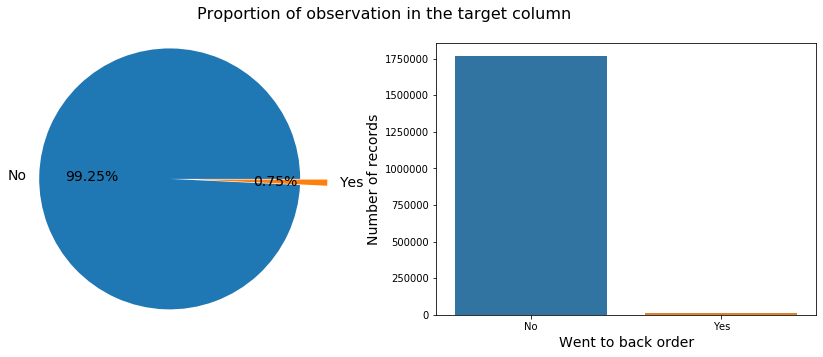

In [49]:
plt.figure(figsize=(15,5))
plt.suptitle('Proportion of observation in the target column',fontsize=16)
plt.subplot(1,2,1)
plt.pie(df['went_on_backorder'].value_counts(),autopct='%0.2f%%',labels=df['went_on_backorder'].value_counts().index,radius=1.2,explode=(0,0.25),textprops={'fontsize':14})

plt.subplot(1,2,2)
sns.barplot(x=df['went_on_backorder'].value_counts().index,y=df['went_on_backorder'].value_counts().values)
plt.xlabel('Went to back order',fontsize=14)
plt.ylabel('Number of records',fontsize=14)
plt.show()

From the data proportions of the target variable, we can see that there is a high imbalance in the dataset.

## Numerical Features

In [50]:
print('The numerical features in the given data set are:\n',list(df.select_dtypes(include=np.number).columns))

The numerical features in the given data set are:
 ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


In [51]:
df.skew()

national_inv         418.592908
lead_time              4.638832
in_transit_qty       173.118373
forecast_3_month     137.364138
forecast_6_month     133.611086
forecast_9_month     137.415357
sales_1_month        205.044521
sales_3_month        141.231755
sales_6_month        141.578385
sales_9_month        136.536986
min_bank             108.767783
pieces_past_due      401.945135
perf_6_month_avg      -1.579856
perf_12_month_avg     -1.619106
local_bo_qty         150.943159
dtype: float64

### 1. National Inventory

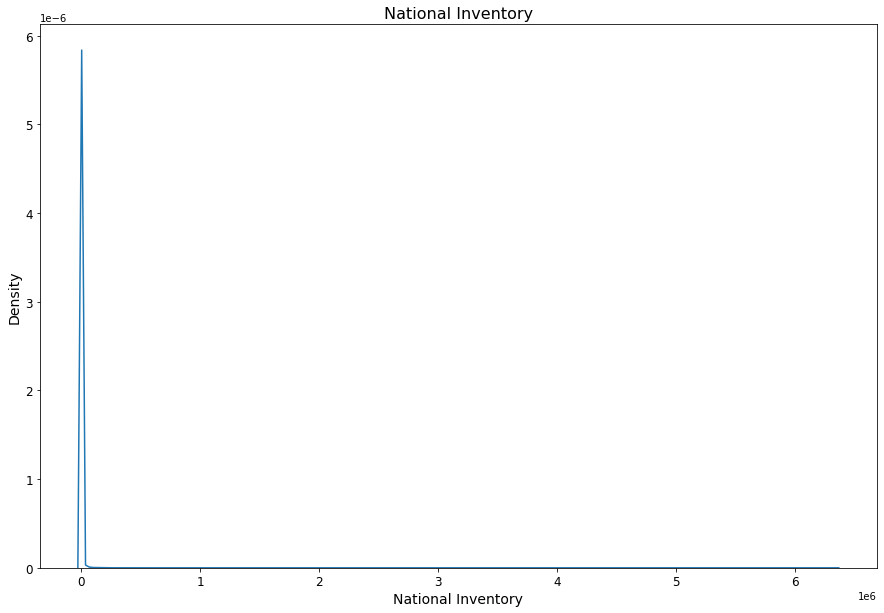

In [27]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['national_inv'])
plt.title('National Inventory',fontsize=16)
plt.xlabel('National Inventory',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

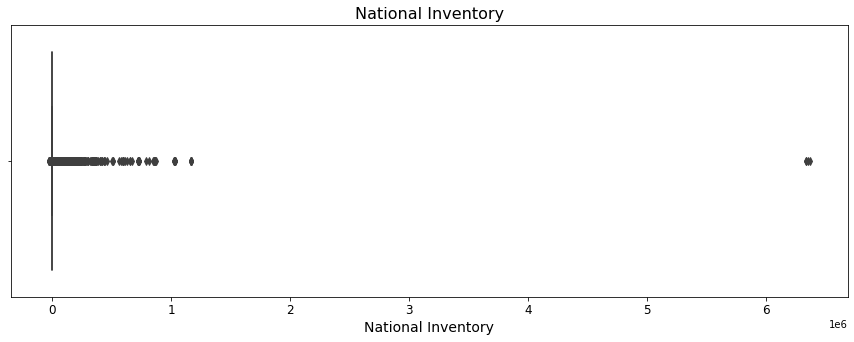

In [28]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['national_inv'])
plt.title('National Inventory',fontsize=16)
plt.xlabel('National Inventory',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [29]:
print('Skewness =',df['national_inv'].skew())
print('Kurtosis =',df['national_inv'].kurt())

Skewness = 418.592907603696
Kurtosis = 228335.15157241857


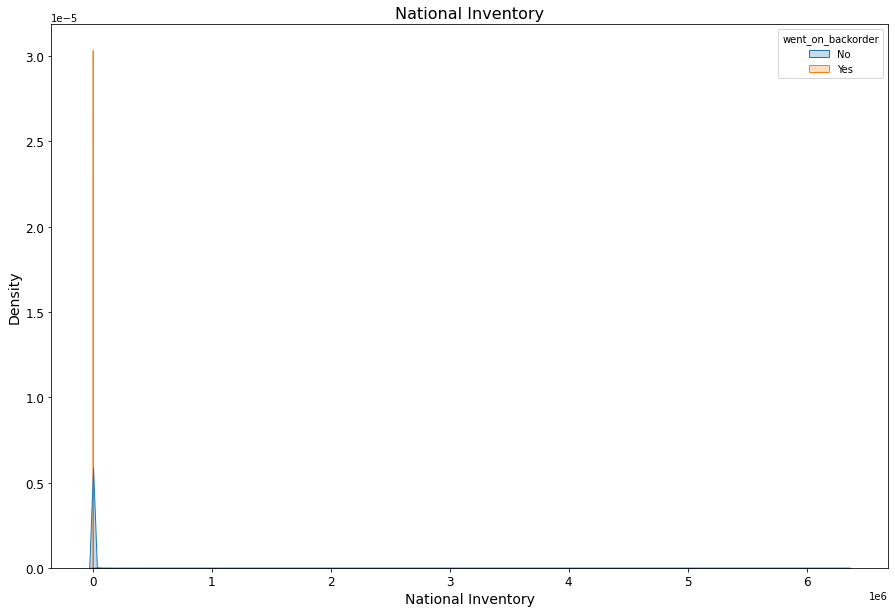

In [30]:
# Relation between National Inventory & went_on_backorder(target variable)

plt.figure(figsize=(15,10))
sns.kdeplot(x='national_inv',hue='went_on_backorder',data=df,fill=True)
plt.title('National Inventory',fontsize=16)
plt.xlabel('National Inventory',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

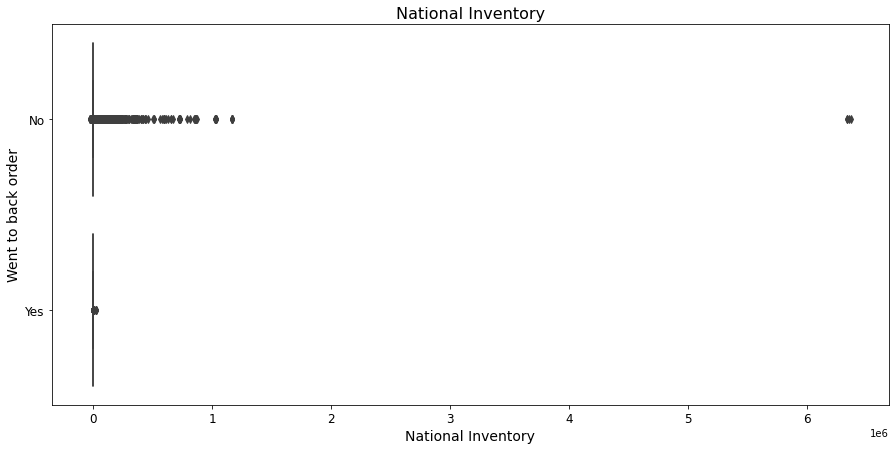

In [31]:
plt.figure(figsize=(15,7))
sns.boxplot(x='national_inv',y='went_on_backorder',data=df)
plt.title('National Inventory',fontsize=16)
plt.xlabel('National Inventory',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

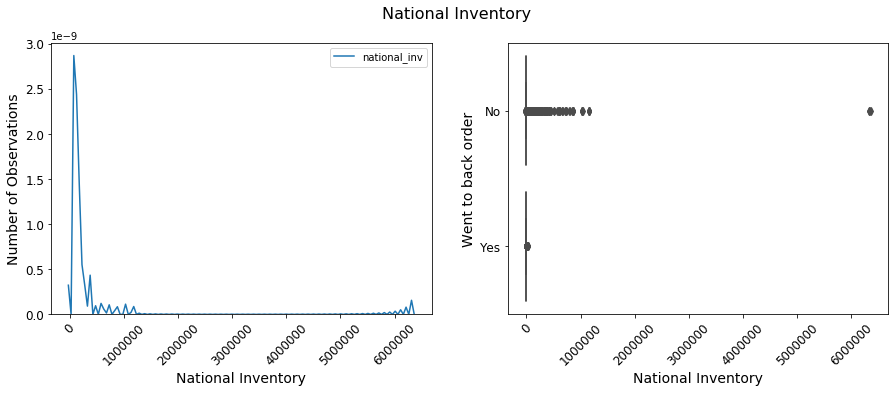

In [18]:
plt.figure(figsize=(15,5))
plt.suptitle('National Inventory',fontsize=16)
plt.subplot(1,2,1)
sns.kdeplot(df['national_inv'])
plt.xlabel('National Inventory',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='national_inv',y='went_on_backorder',data=df,color='b')
plt.xlabel('National Inventory',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From the above graphs we can see that the data is highly right skewed and has high kurtosis.

When we split the plots based on the target variable, we can see that the extent of outliers are more for the No category as compared to Yes.

We can see that the data for the yes category has the highest points near 0.

Here we can see that when the product goes to back order, the national inventory is 0. That is there is high chance for the product to go to back order when the national inventory is 0.

In both the classes we can see that the values have gone to negative side as well.

### 2.lead_time

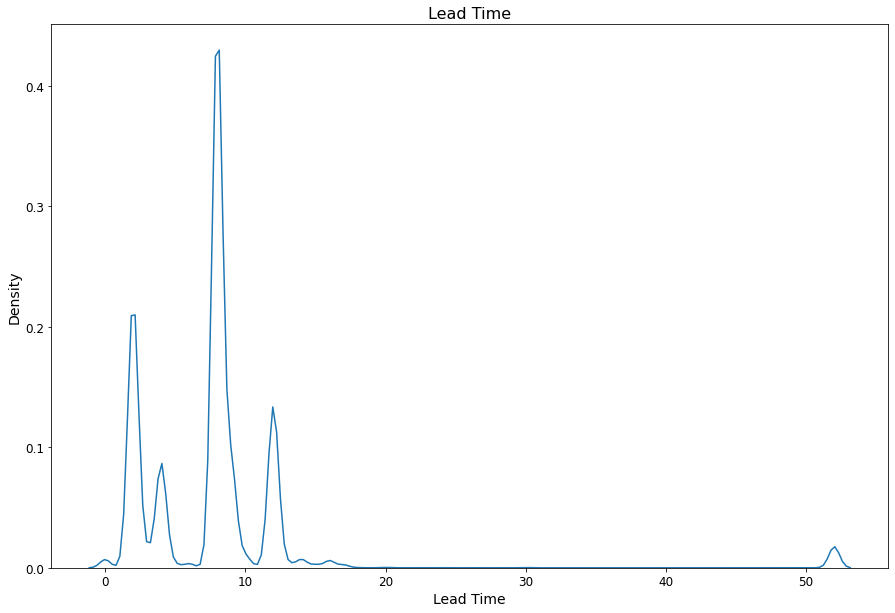

In [32]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['lead_time'])
plt.title('Lead Time',fontsize=16)
plt.xlabel('Lead Time',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

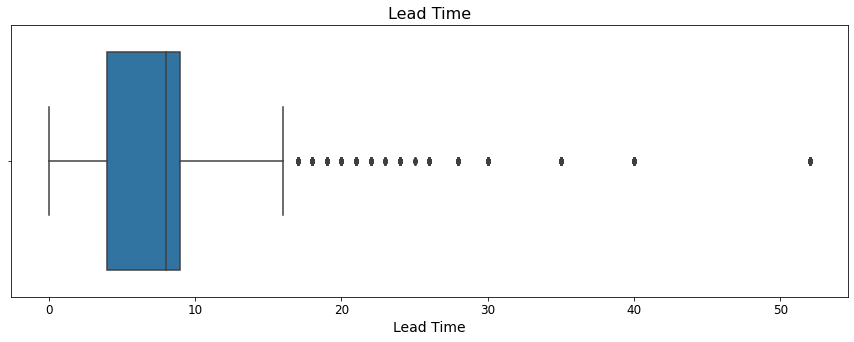

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['lead_time'])
plt.title('Lead Time',fontsize=16)
plt.xlabel('Lead Time',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [34]:
print('Skewness =',df['lead_time'].skew())
print('Kurtosis =',df['lead_time'].kurt())

Skewness = 4.638832393515835
Kurtosis = 28.258101368469585


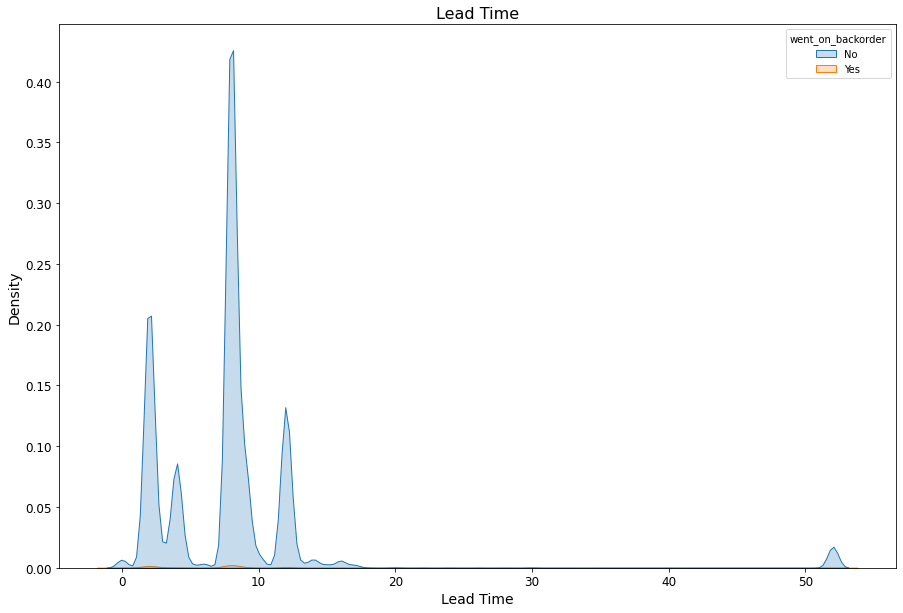

In [35]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='lead_time',hue='went_on_backorder',data=df,fill=True)
plt.title('Lead Time',fontsize=16)
plt.xlabel('Lead Time',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

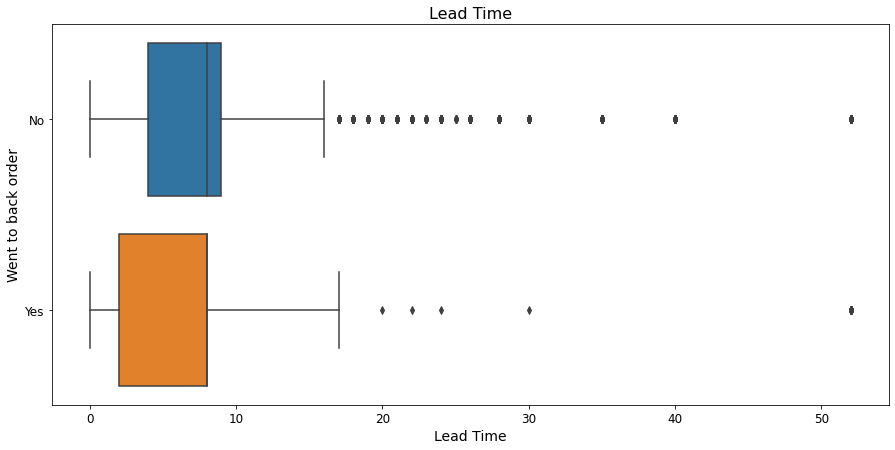

In [36]:
plt.figure(figsize=(15,7))
sns.boxplot(x='lead_time',y='went_on_backorder',data=df)
plt.title('Lead Time',fontsize=16)
plt.xlabel('Lead Time',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

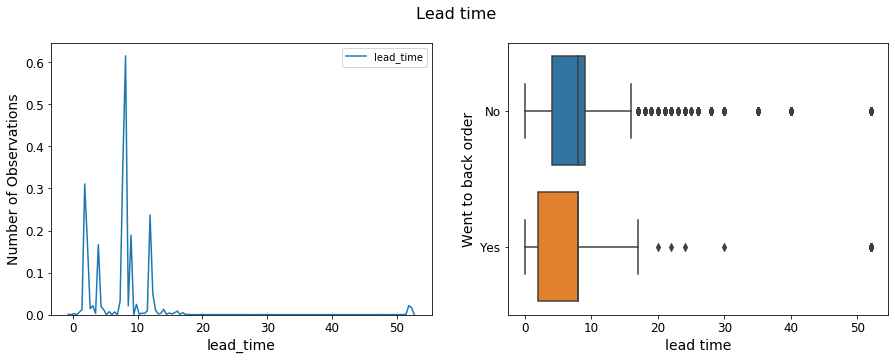

In [14]:
plt.figure(figsize=(15,5))
plt.suptitle('Lead time',fontsize=16)
plt.subplot(1,2,1)
sns.kdeplot(df['lead_time'])
plt.xlabel('lead_time',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='lead_time',y='went_on_backorder',data=df)
plt.xlabel('lead time',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data for lead time is right skewed. And has high kurtosis.

The data split based on target varable show a similar dispersion pattern.

Both the data have outliers with similar values.

### 3. in_transit_qty

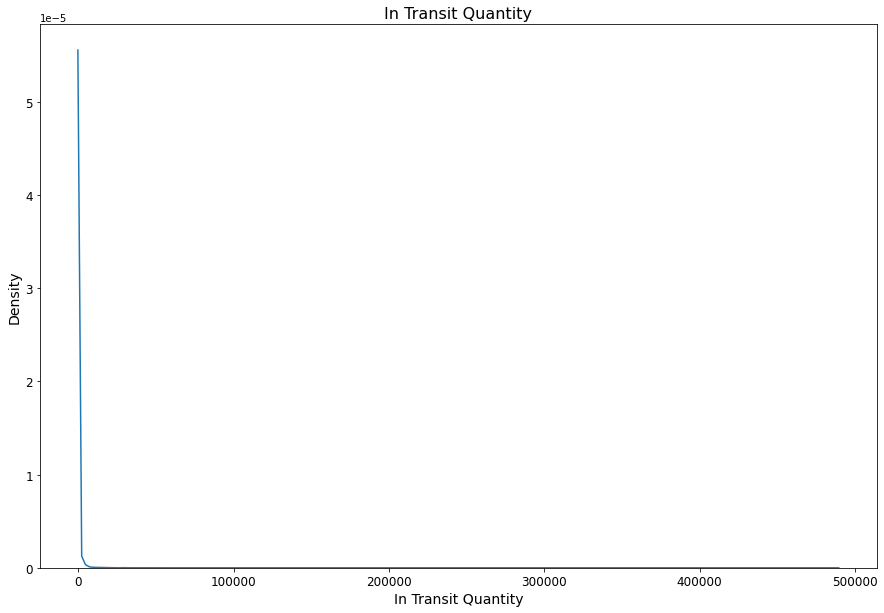

In [37]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['in_transit_qty'])
plt.title('In Transit Quantity',fontsize=16)
plt.xlabel('In Transit Quantity',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

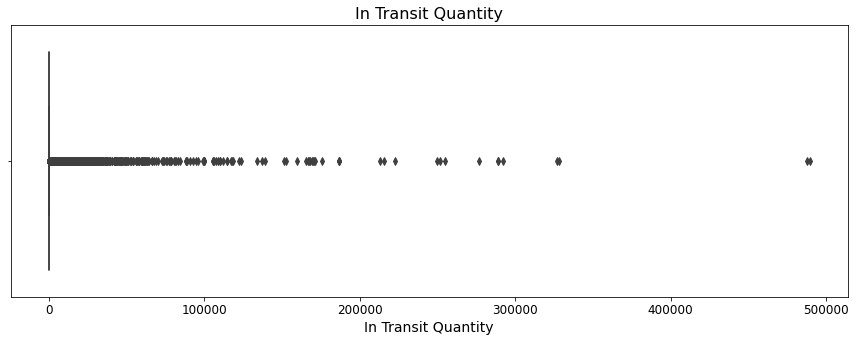

In [38]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['in_transit_qty'])
plt.title('In Transit Quantity',fontsize=16)
plt.xlabel('In Transit Quantity',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [39]:
print('Skewness =',df['in_transit_qty'].skew())
print('Kurtosis =',df['in_transit_qty'].kurt())

Skewness = 173.11837307153814
Kurtosis = 44910.369805817245


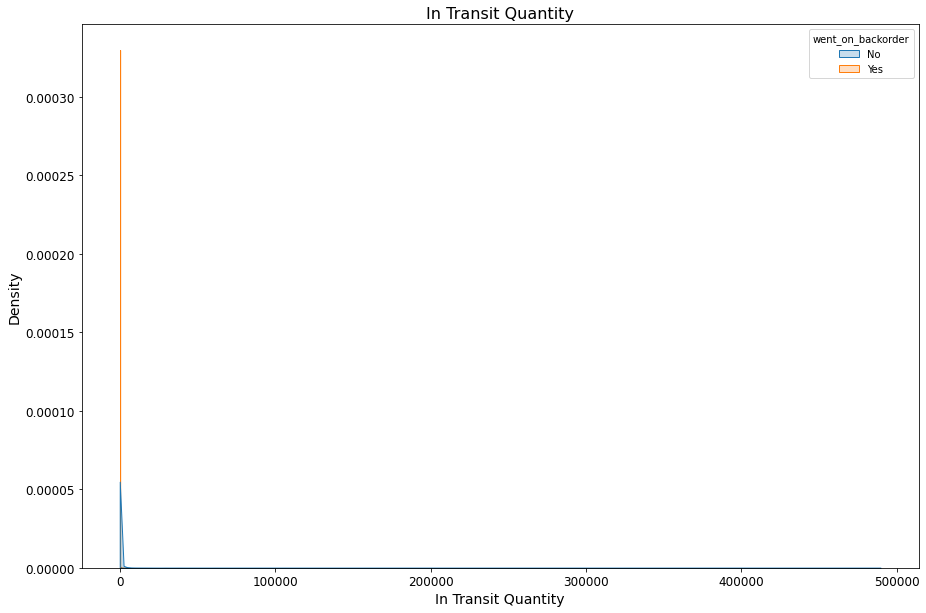

In [14]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='in_transit_qty',hue='went_on_backorder',data=df,fill=True)
plt.title('In Transit Quantity',fontsize=16)
plt.xlabel('In Transit Quantity',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

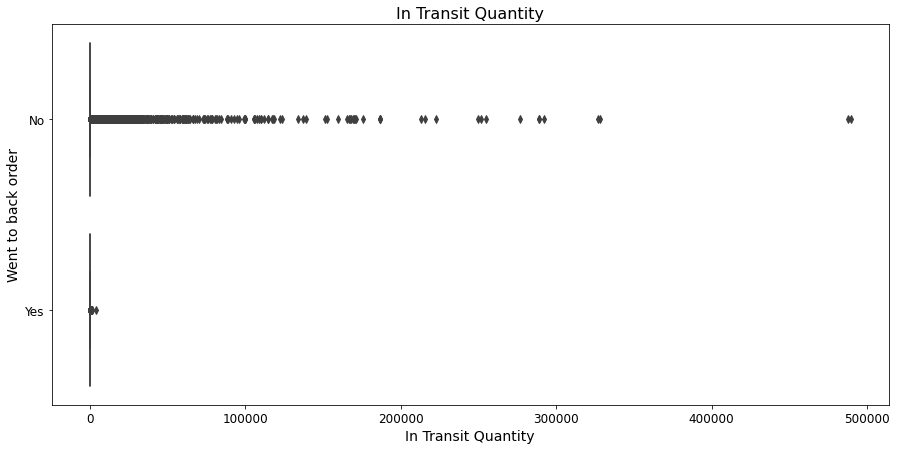

In [41]:
plt.figure(figsize=(15,7))
sns.boxplot(x='in_transit_qty',y='went_on_backorder',data=df)
plt.title('In Transit Quantity',fontsize=16)
plt.xlabel('In Transit Quantity',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

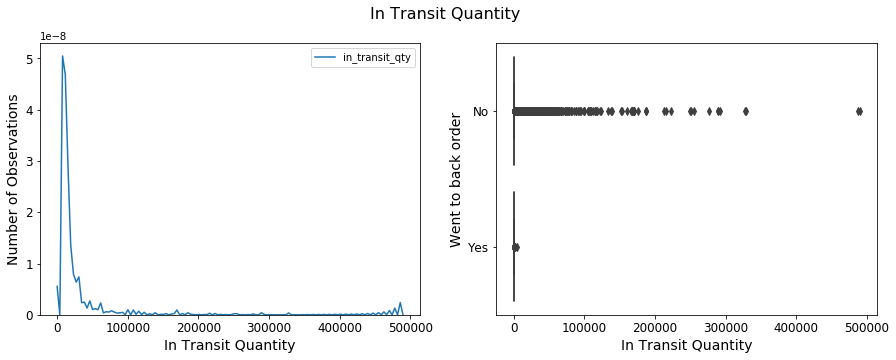

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('In Transit Quantity',fontsize=16)
sns.kdeplot(df['in_transit_qty'])
plt.xlabel('In Transit Quantity',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='in_transit_qty',y='went_on_backorder',data=df)
plt.xlabel('In Transit Quantity',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is highly right skewed and has high kurtosis.

The in transit quantity for went to back order is maximum concentrated at 0. This is because, the feature in transit quantity  actually refers to the products which are already avialable, if it is available then chances of the product going to back order is very less. The few points which are shown with value other than 0 maybe indicating that the product might have got stuck in some part of the delivery, and that has lead to the product to go to back order status.

we can see that No category in the went to back order has high number of outliers in intransit quantity and most dense area is near to zero.

### 4. forecast_3_month

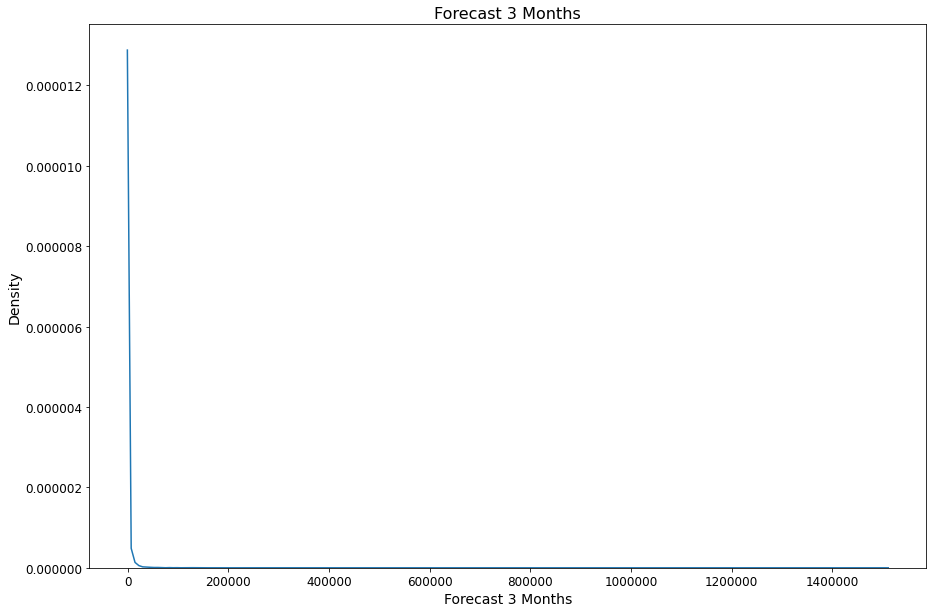

In [42]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['forecast_3_month'])
plt.title('Forecast 3 Months',fontsize=16)
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

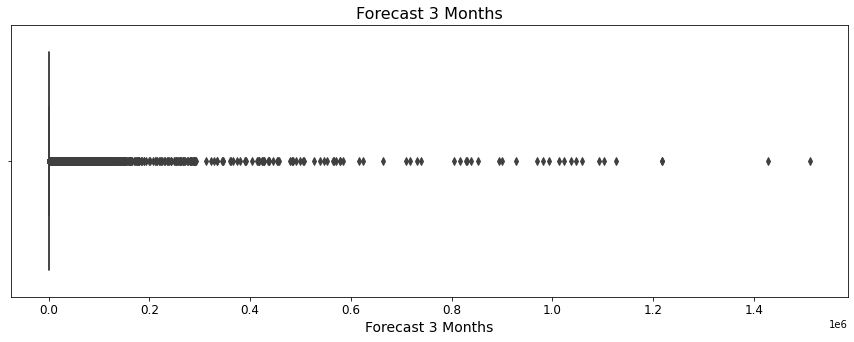

In [44]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['forecast_3_month'])
plt.title('Forecast 3 Months',fontsize=16)
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [45]:
print('Skewness =',df['forecast_3_month'].skew())
print('Kurtosis =',df['forecast_3_month'].kurt())

Skewness = 137.36413841780094
Kurtosis = 25242.86481259942


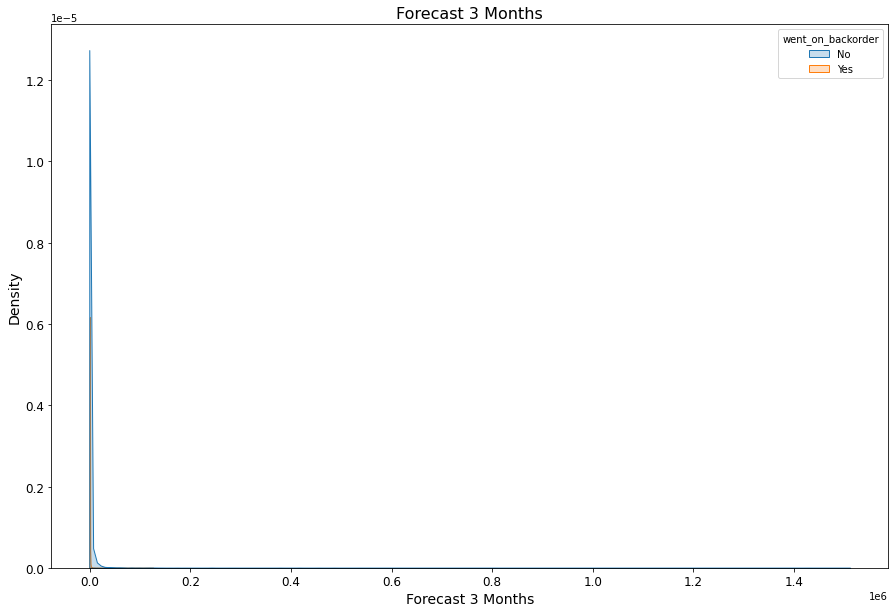

In [46]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='forecast_3_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Forecast 3 Months',fontsize=16)
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

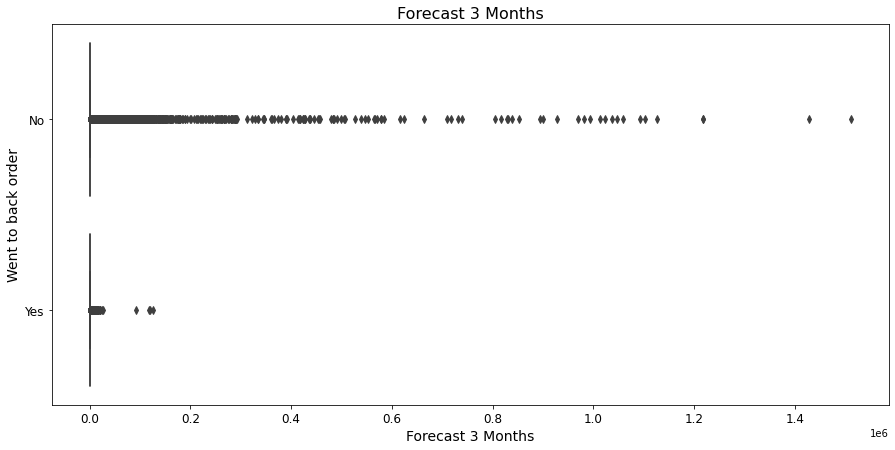

In [47]:
plt.figure(figsize=(15,7))
sns.boxplot(x='forecast_3_month',y='went_on_backorder',data=df)
plt.title('Forecast 3 Months',fontsize=16)
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

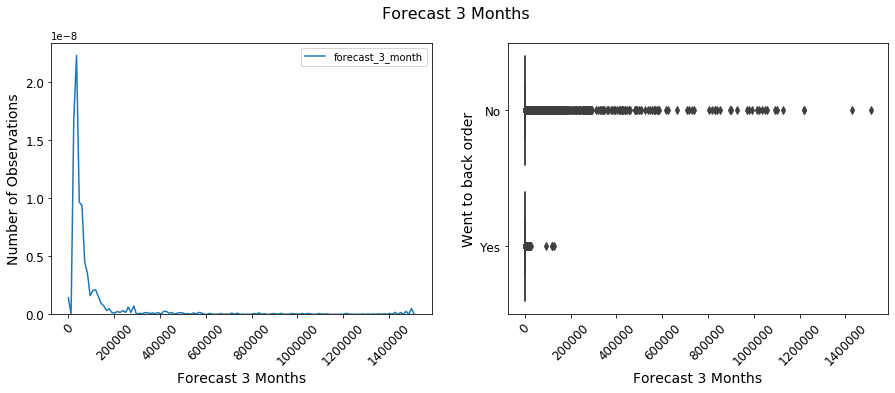

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Forecast 3 Months',fontsize=16)
sns.kdeplot(df['forecast_3_month'])
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='forecast_3_month',y='went_on_backorder',data=df)
plt.xlabel('Forecast 3 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This data is highly right skewed and has large kurtosis.

When split based on the target variable, the no category has large value of outliers present as compared to the yes category.

### 5. forecast_6_month

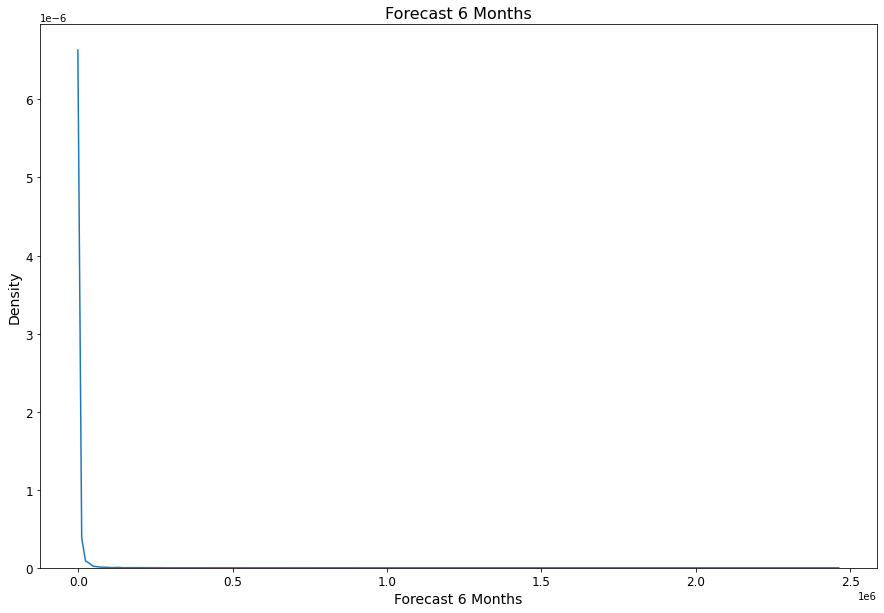

In [48]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['forecast_6_month'])
plt.title('Forecast 6 Months',fontsize=16)
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

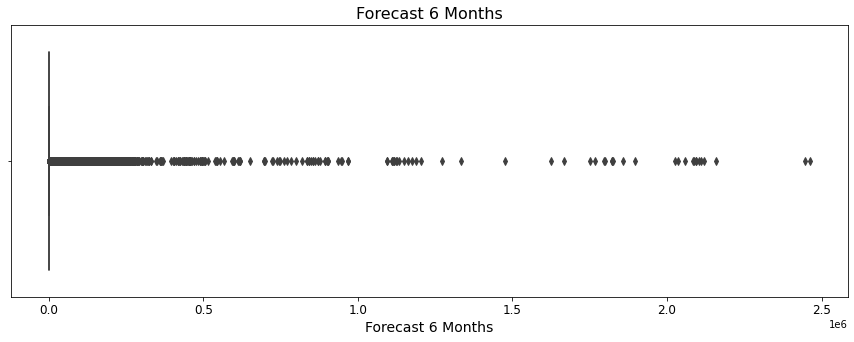

In [49]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['forecast_6_month'])
plt.title('Forecast 6 Months',fontsize=16)
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [50]:
print('Skewness =',df['forecast_6_month'].skew())
print('Kurtosis =',df['forecast_6_month'].kurt())

Skewness = 133.6110855876186
Kurtosis = 23208.303144641475


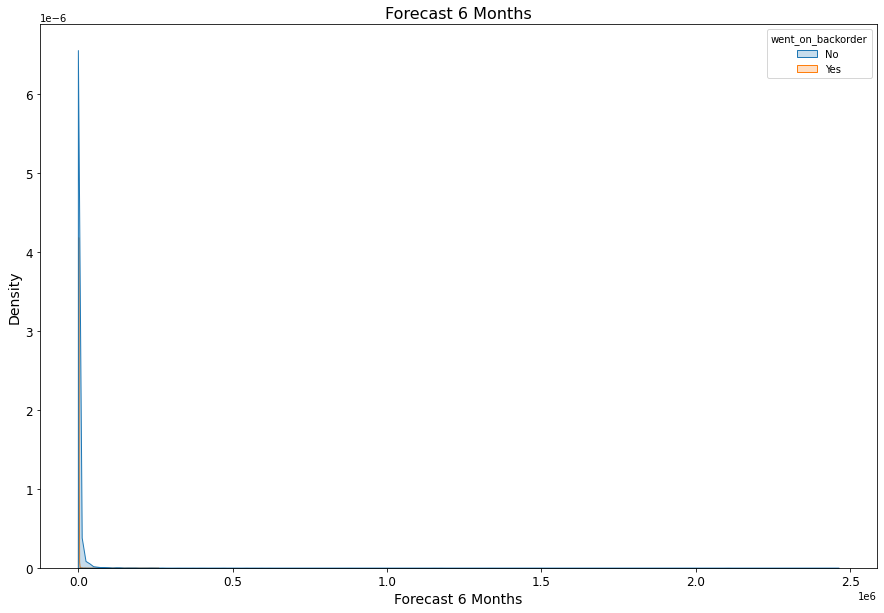

In [51]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='forecast_6_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Forecast 6 Months',fontsize=16)
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

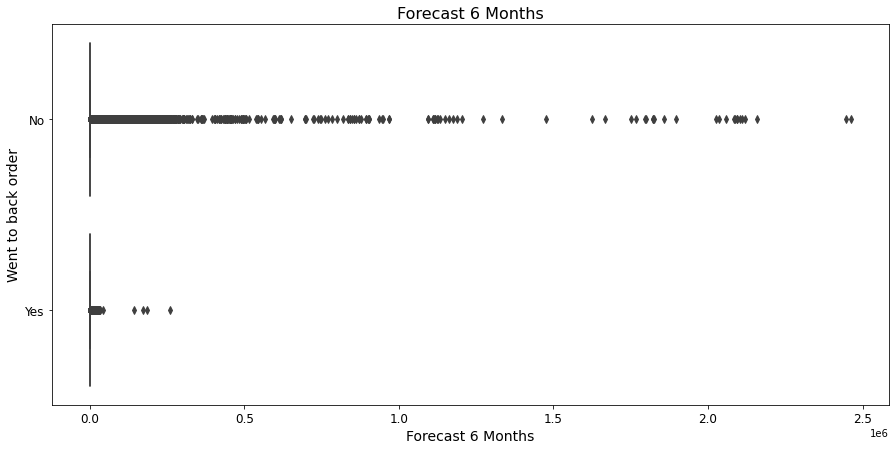

In [52]:
plt.figure(figsize=(15,7))
sns.boxplot(x='forecast_6_month',y='went_on_backorder',data=df)
plt.title('Forecast 6 Months',fontsize=16)
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

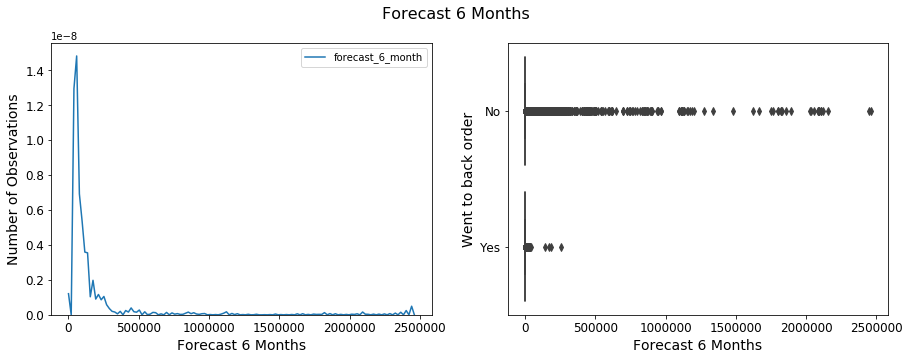

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Forecast 6 Months',fontsize=16)
sns.kdeplot(df['forecast_6_month'])
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

plt.subplot(1,2,2)
sns.boxplot(x='forecast_6_month',y='went_on_backorder',data=df)
plt.xlabel('Forecast 6 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This shows similar behaviour with forecast 3 month data.

### 6. forecast_9_month

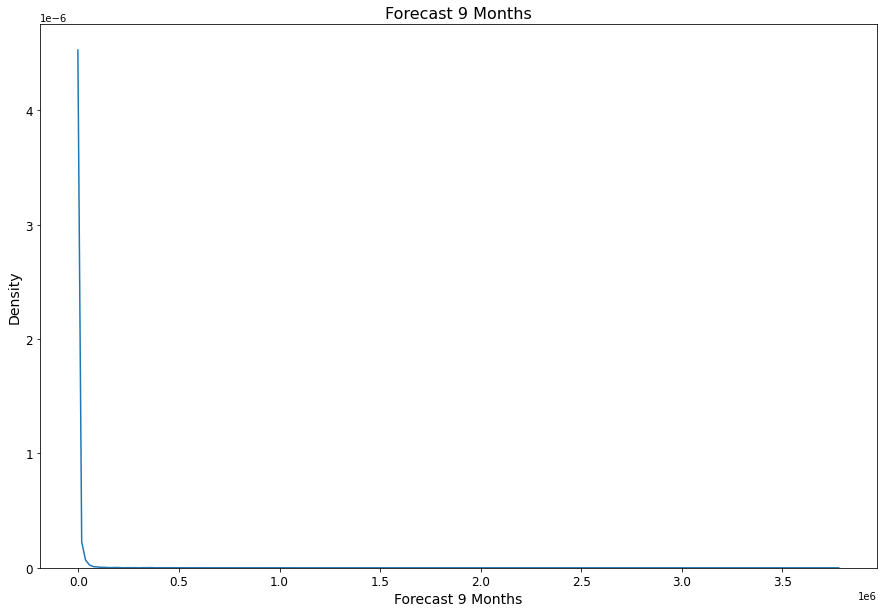

In [53]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['forecast_9_month'])
plt.title('Forecast 9 Months',fontsize=16)
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

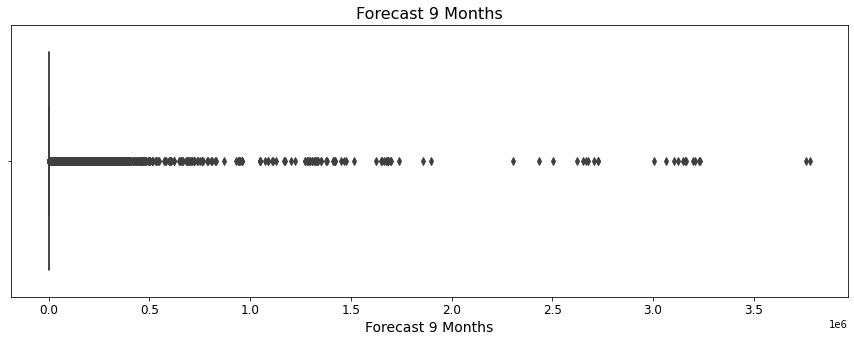

In [54]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['forecast_9_month'])
plt.title('Forecast 9 Months',fontsize=16)
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [55]:
print('Skewness =',df['forecast_9_month'].skew())
print('Kurtosis =',df['forecast_9_month'].kurt())

Skewness = 137.41535676495113
Kurtosis = 24853.399528250367


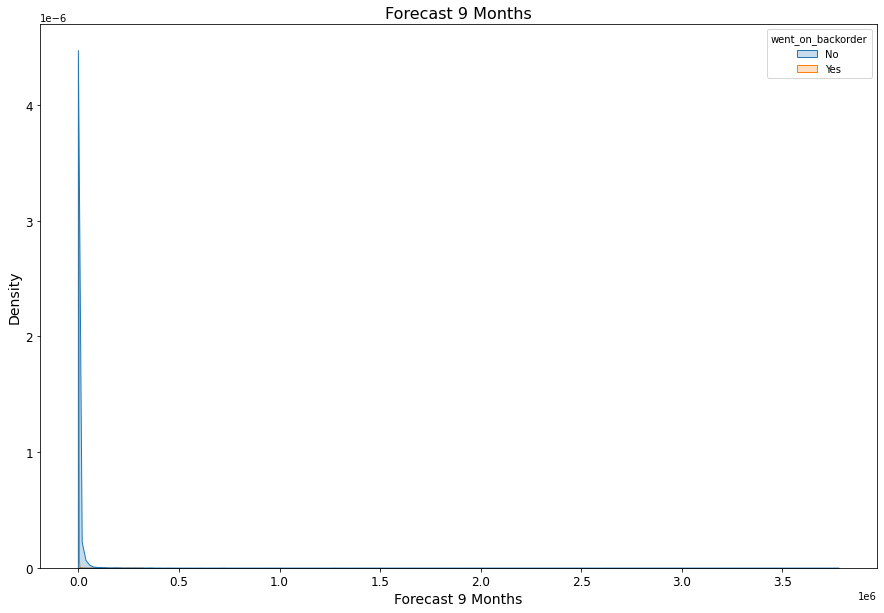

In [56]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='forecast_9_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Forecast 9 Months',fontsize=16)
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

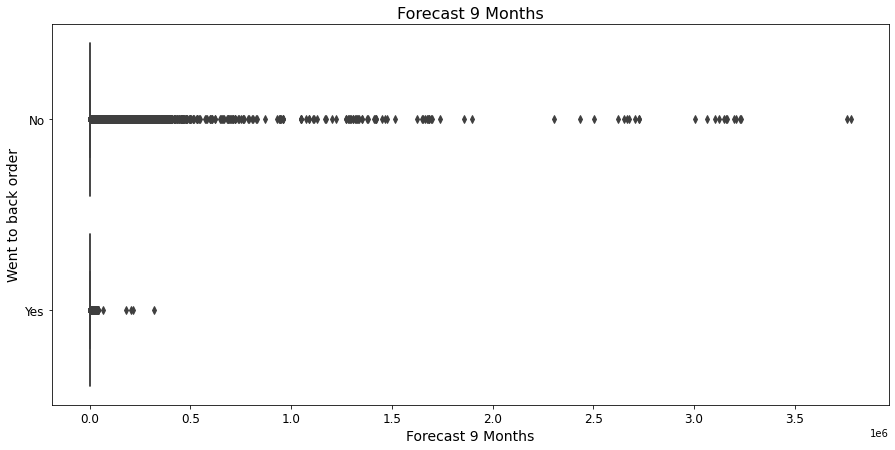

In [57]:
plt.figure(figsize=(15,7))
sns.boxplot(x='forecast_9_month',y='went_on_backorder',data=df)
plt.title('Forecast 9 Months',fontsize=16)
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

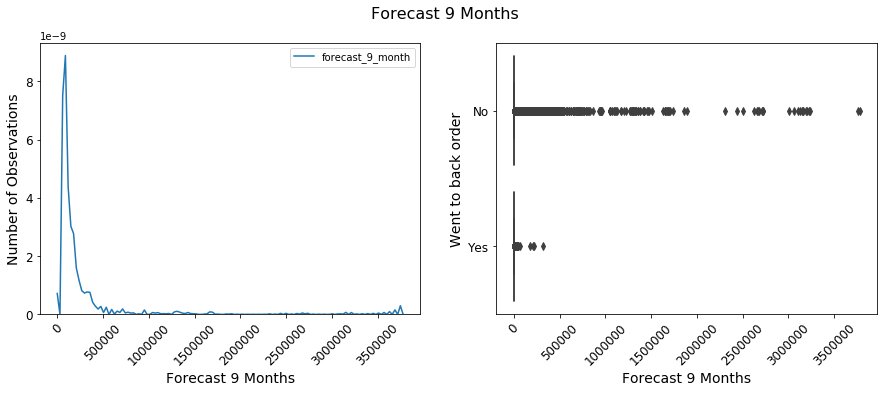

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Forecast 9 Months',fontsize=16)
sns.kdeplot(df['forecast_9_month'])
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='forecast_9_month',y='went_on_backorder',data=df)
plt.xlabel('Forecast 9 Months',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The forecast 9 month feature behaves similary to the previous 2 forecast features.

### 7. sales_1_month

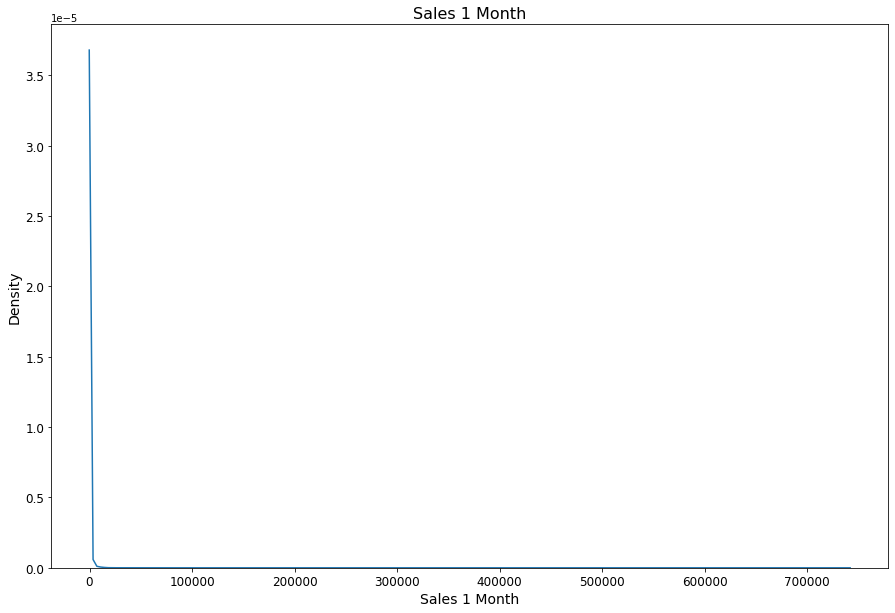

In [58]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['sales_1_month'])
plt.title('Sales 1 Month',fontsize=16)
plt.xlabel('Sales 1 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

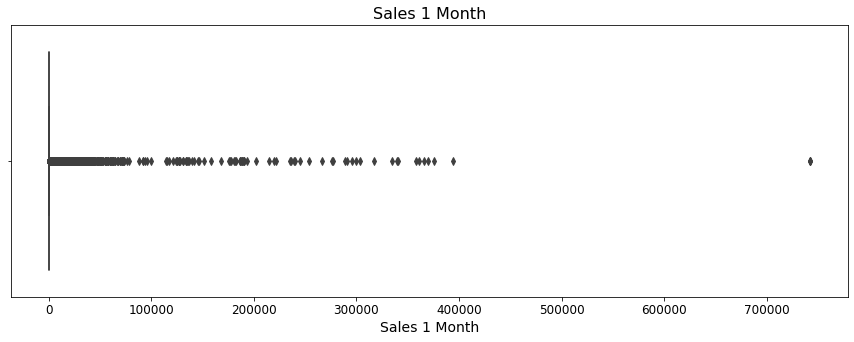

In [59]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['sales_1_month'])
plt.title('Sales 1 Month',fontsize=16)
plt.xlabel('Sales 1 Month',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [60]:
print('Skewness =',df['sales_1_month'].skew())
print('Kurtosis =',df['sales_1_month'].kurt())

Skewness = 205.04452122583152
Kurtosis = 61305.66403651171


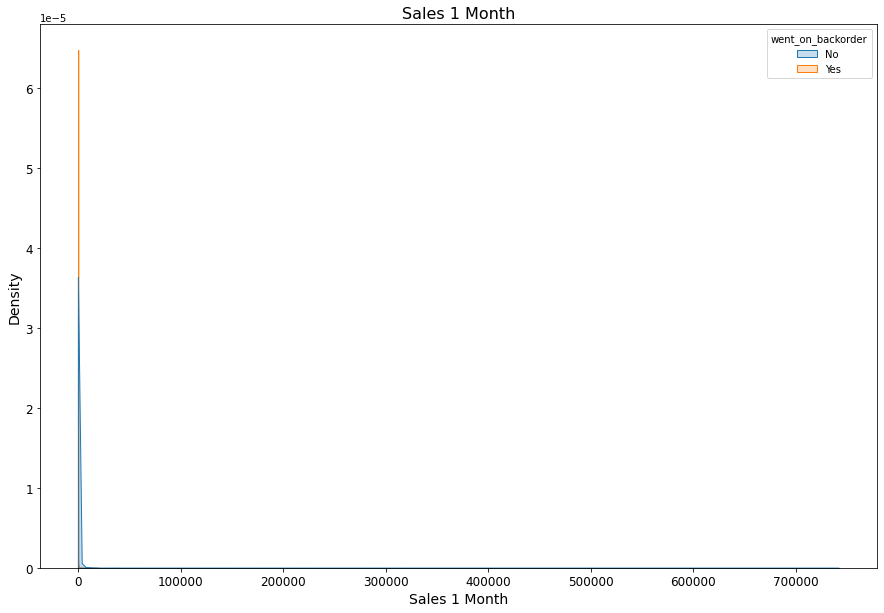

In [61]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='sales_1_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Sales 1 Month',fontsize=16)
plt.xlabel('Sales 1 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

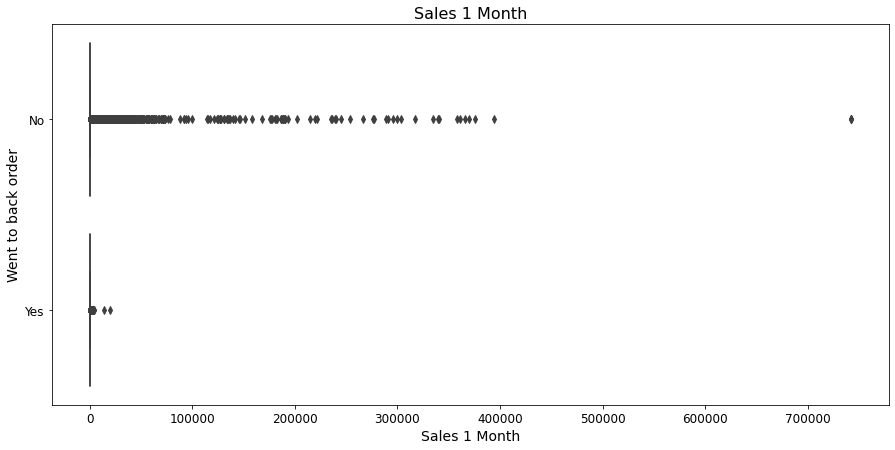

In [62]:
plt.figure(figsize=(15,7))
sns.boxplot(x='sales_1_month',y='went_on_backorder',data=df)
plt.title('Sales 1 Month',fontsize=16)
plt.xlabel('Sales 1 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

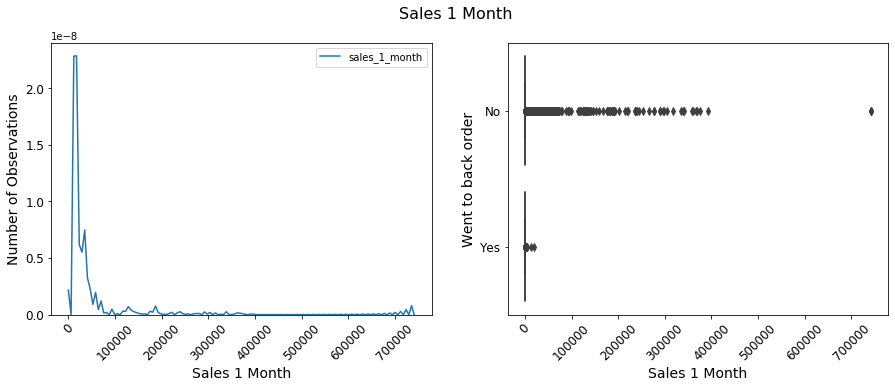

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Sales 1 Month',fontsize=16)
sns.kdeplot(df['sales_1_month'])
plt.xlabel('Sales 1 Month',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='sales_1_month',y='went_on_backorder',data=df)
plt.xlabel('Sales 1 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is highly right skewed and has high kurtosis.

When split based on the target variable we can see that both the categories have large number of observations around 0 mark.

The no category has more widely spread outliers while the outliers for the yes category are fewer in number and present closer to each other.

The Yes category has more number of records at 0 value as compared to No category.

### 8. sales_3_month

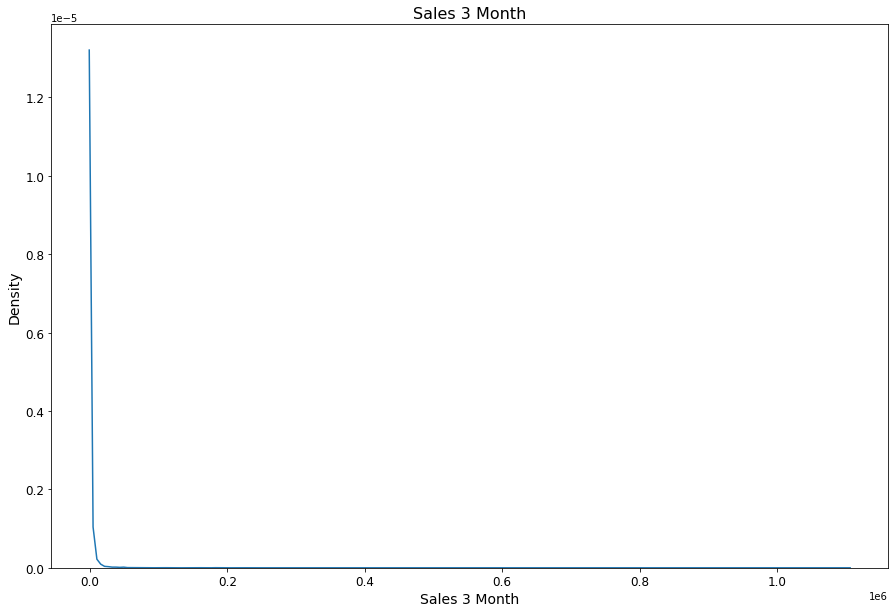

In [63]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['sales_3_month'])
plt.title('Sales 3 Month',fontsize=16)
plt.xlabel('Sales 3 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

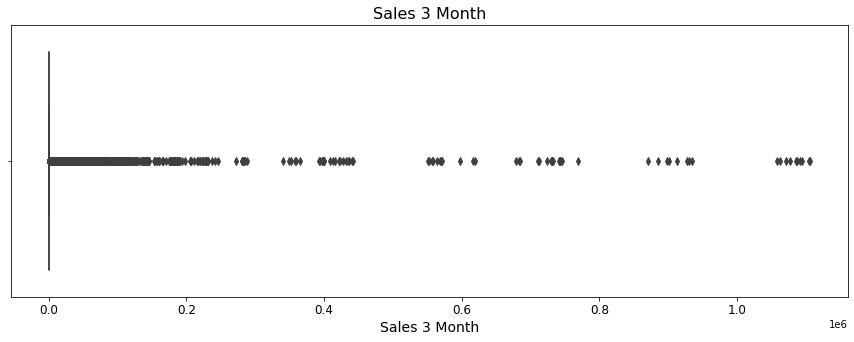

In [64]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['sales_3_month'])
plt.title('Sales 3 Month',fontsize=16)
plt.xlabel('Sales 3 Month',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [65]:
print('Skewness =',df['sales_3_month'].skew())
print('Kurtosis =',df['sales_3_month'].kurt())

Skewness = 141.23175538715816
Kurtosis = 24637.39996621289


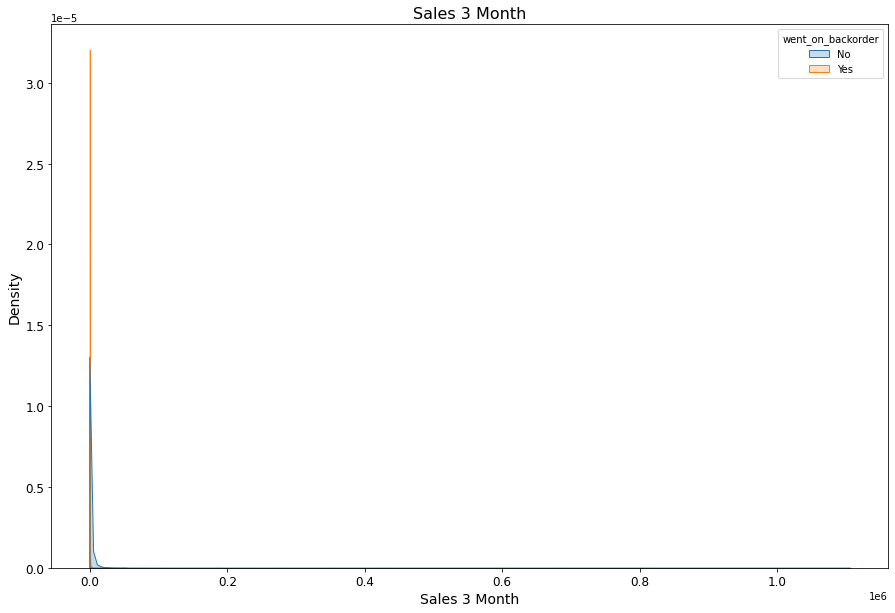

In [66]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='sales_3_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Sales 3 Month',fontsize=16)
plt.xlabel('Sales 3 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

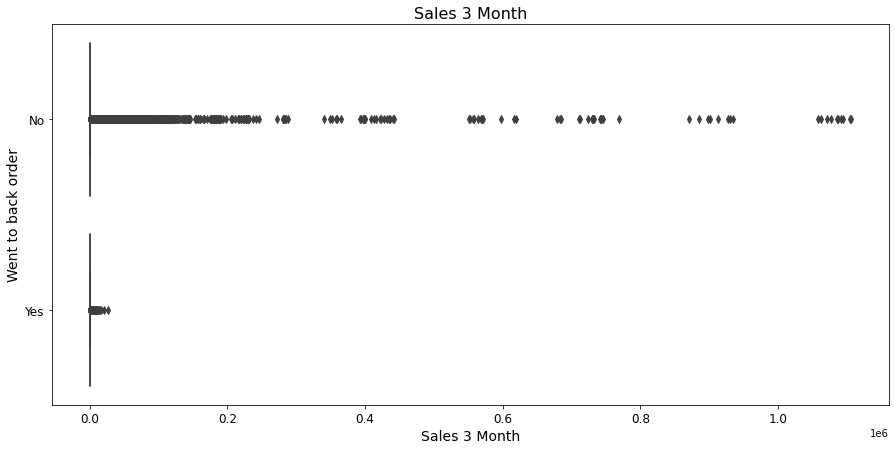

In [67]:
plt.figure(figsize=(15,7))
sns.boxplot(x='sales_3_month',y='went_on_backorder',data=df)
plt.title('Sales 3 Month',fontsize=16)
plt.xlabel('Sales 3 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

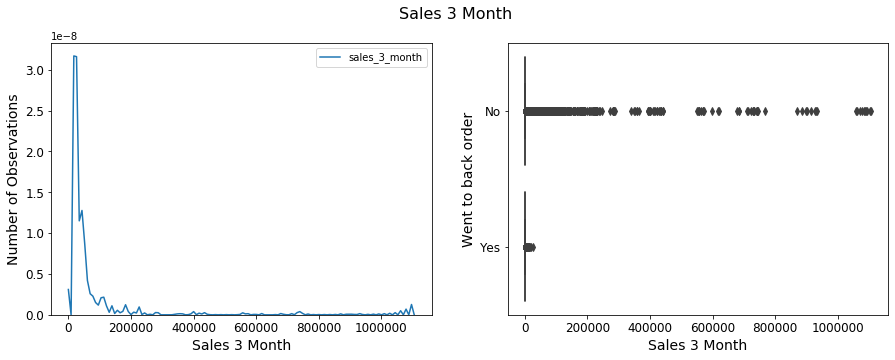

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Sales 3 Month',fontsize=16)
sns.kdeplot(df['sales_3_month'])
plt.xlabel('Sales 3 Month',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='sales_3_month',y='went_on_backorder',data=df)
plt.xlabel('Sales 3 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Sales 3 months feature his right skewed and has high kurtosis.

The behaviour of the data is similar to that of sales 1 month.

### 9. sales_6_month

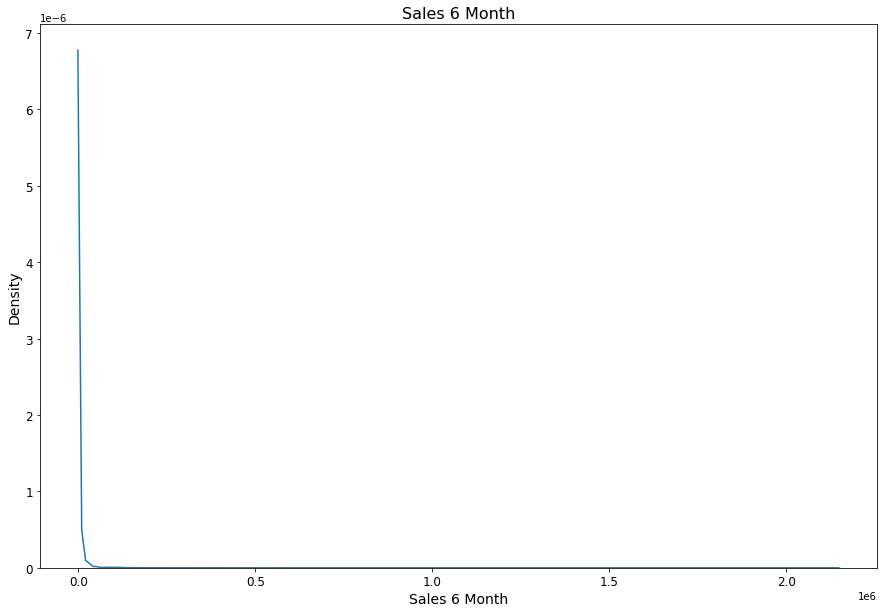

In [68]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['sales_6_month'])
plt.title('Sales 6 Month',fontsize=16)
plt.xlabel('Sales 6 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

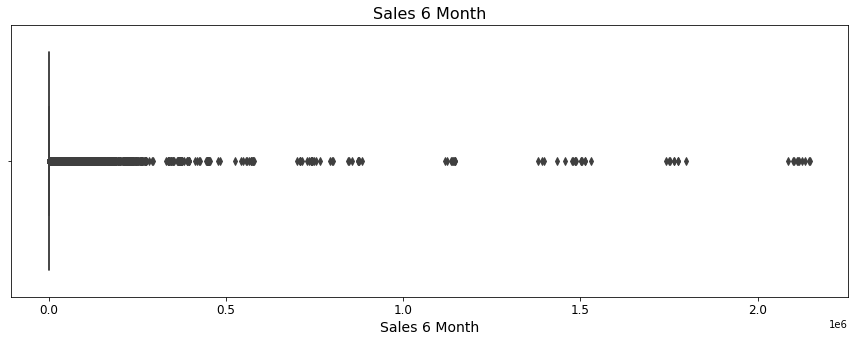

In [69]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['sales_6_month'])
plt.title('Sales 6 Month',fontsize=16)
plt.xlabel('Sales 6 Month',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [70]:
print('Variance = ',df['sales_6_month'].var())
print('Skewness =',df['sales_6_month'].skew())
print('Kurtosis =',df['sales_6_month'].kurt())

Variance =  92525499.89792402
Skewness = 141.57838516910718
Kurtosis = 25037.015800233155


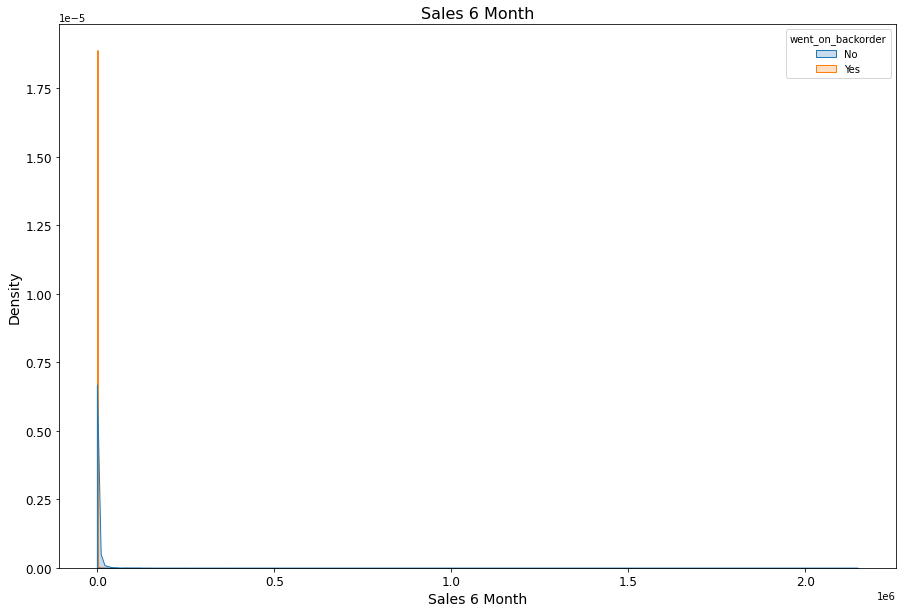

In [71]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='sales_6_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Sales 6 Month',fontsize=16)
plt.xlabel('Sales 6 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

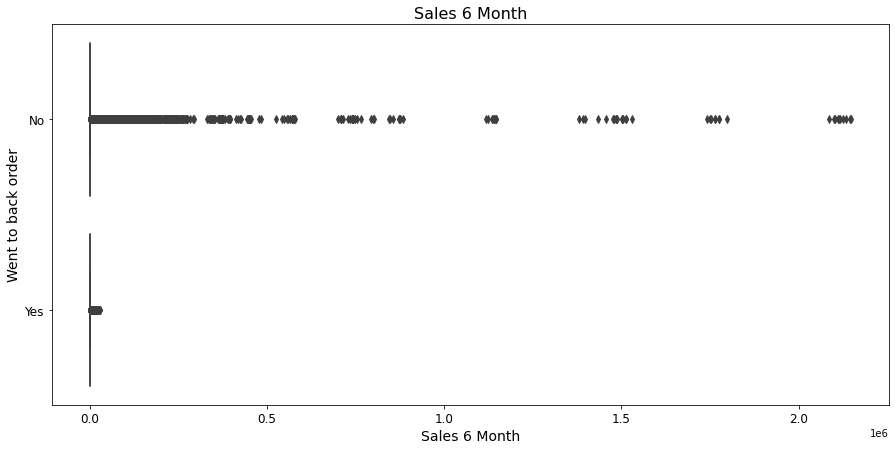

In [72]:
plt.figure(figsize=(15,7))
sns.boxplot(x='sales_6_month',y='went_on_backorder',data=df)
plt.title('Sales 6 Month',fontsize=16)
plt.xlabel('Sales 6 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

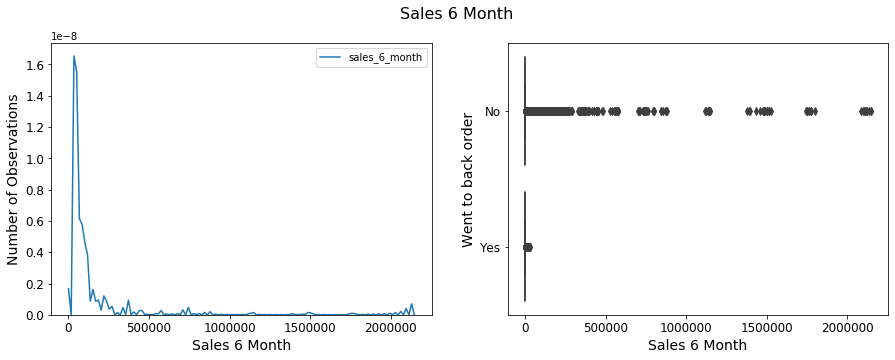

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Sales 6 Month',fontsize=16)
sns.kdeplot(df['sales_6_month'])
plt.xlabel('Sales 6 Month',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='sales_6_month',y='went_on_backorder',data=df)
plt.xlabel('Sales 6 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is right skewed and has high kurtosis.

The behaviour of data is similar to 3 month sales feature.

### 10. sales_9_month

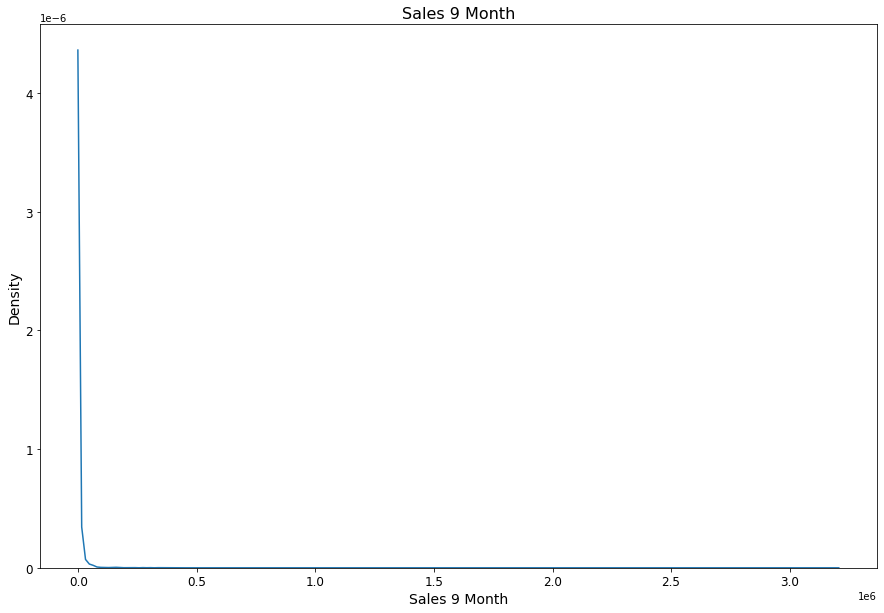

In [73]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['sales_9_month'])
plt.title('Sales 9 Month',fontsize=16)
plt.xlabel('Sales 9 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

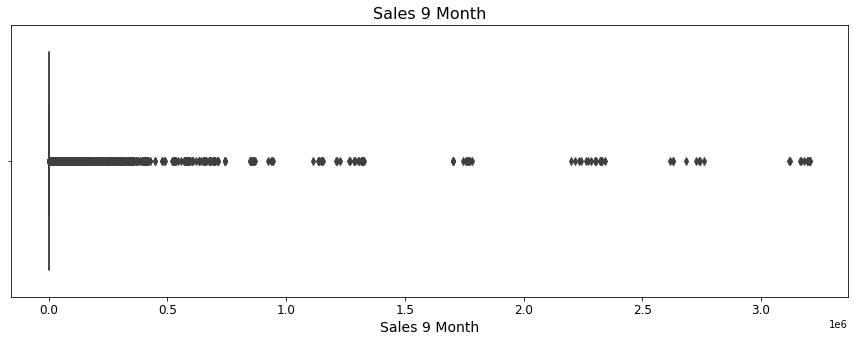

In [74]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['sales_9_month'])
plt.title('Sales 9 Month',fontsize=16)
plt.xlabel('Sales 9 Month',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [75]:
print('Variance = ',df['sales_9_month'].var())
print('Skewness =',df['sales_9_month'].skew())
print('Kurtosis =',df['sales_9_month'].kurt())

Variance =  224439407.39068586
Skewness = 136.53698626252984
Kurtosis = 23111.387137295224


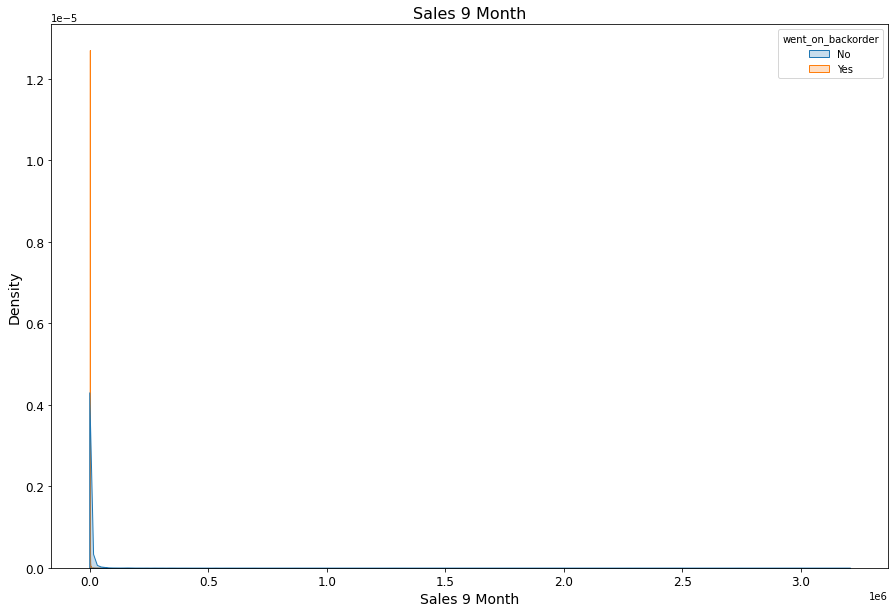

In [76]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='sales_9_month',hue='went_on_backorder',data=df,fill=True)
plt.title('Sales 9 Month',fontsize=16)
plt.xlabel('Sales 9 Month',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

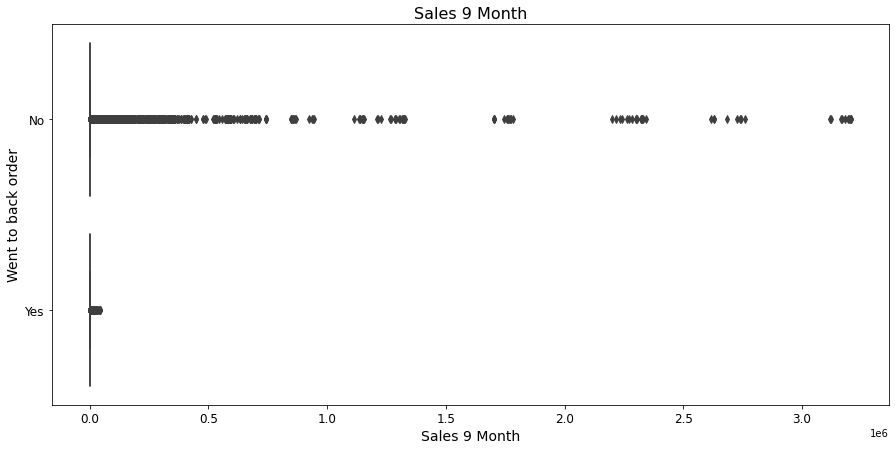

In [77]:
plt.figure(figsize=(15,7))
sns.boxplot(x='sales_9_month',y='went_on_backorder',data=df)
plt.title('Sales 9 Month',fontsize=16)
plt.xlabel('Sales 9 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

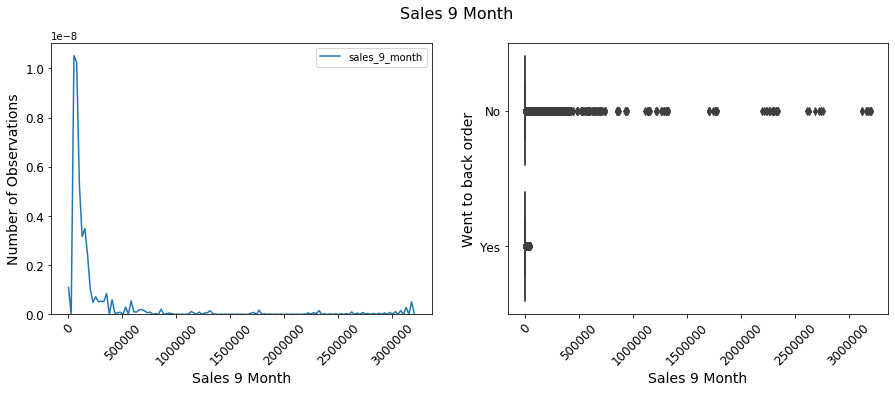

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Sales 9 Month',fontsize=16)
sns.kdeplot(df['sales_9_month'])
plt.xlabel('Sales 9 Month',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='sales_9_month',y='went_on_backorder',data=df)
plt.xlabel('Sales 9 Month',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is right skewed and with high kurtosis.

The behaviour is similar to sales 6 months feature.

### 11. min_bank

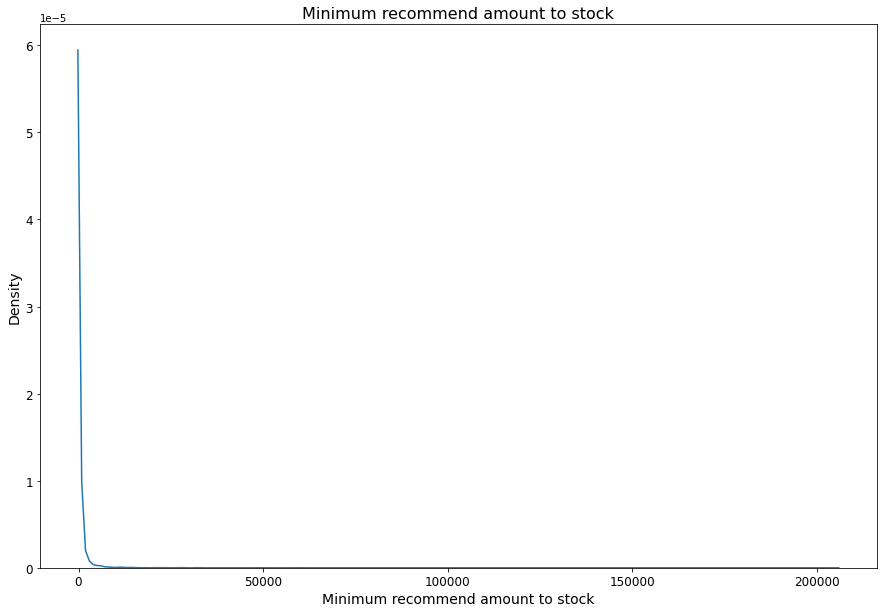

In [78]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['min_bank'])
plt.title('Minimum recommend amount to stock',fontsize=16)
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

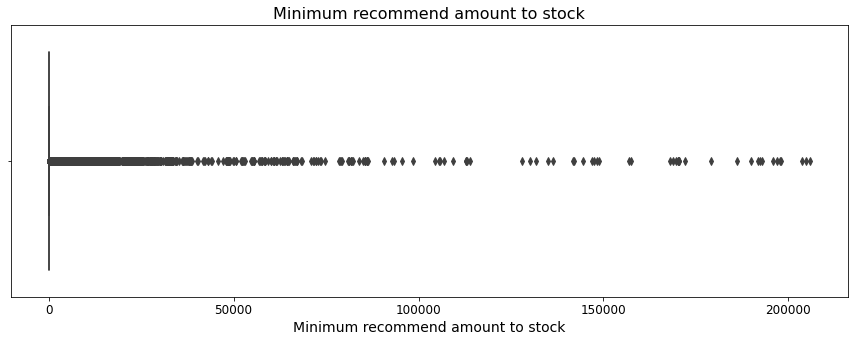

In [79]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['min_bank'])
plt.title('Minimum recommend amount to stock',fontsize=16)
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [80]:
print('Variance = ',df['min_bank'].var())
print('Skewness =',df['min_bank'].skew())
print('Kurtosis =',df['min_bank'].kurt())

Variance =  1121493.757999552
Skewness = 108.76778288884839
Kurtosis = 15833.570208807903


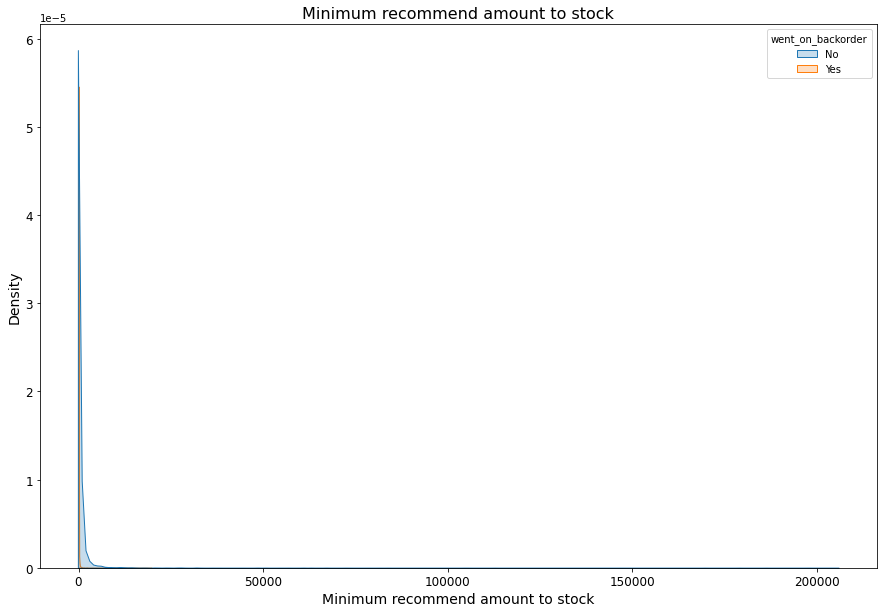

In [81]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='min_bank',hue='went_on_backorder',data=df,fill=True)
plt.title('Minimum recommend amount to stock',fontsize=16)
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

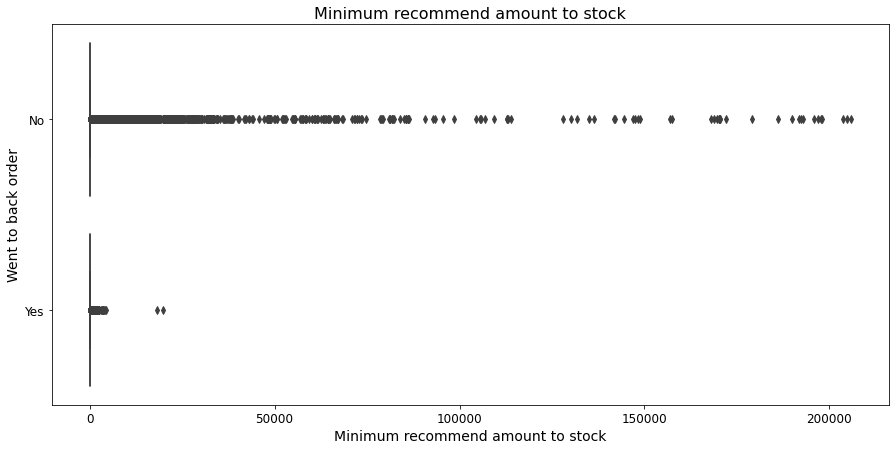

In [82]:
plt.figure(figsize=(15,7))
sns.boxplot(x='min_bank',y='went_on_backorder',data=df)
plt.title('Minimum recommend amount to stock',fontsize=16)
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

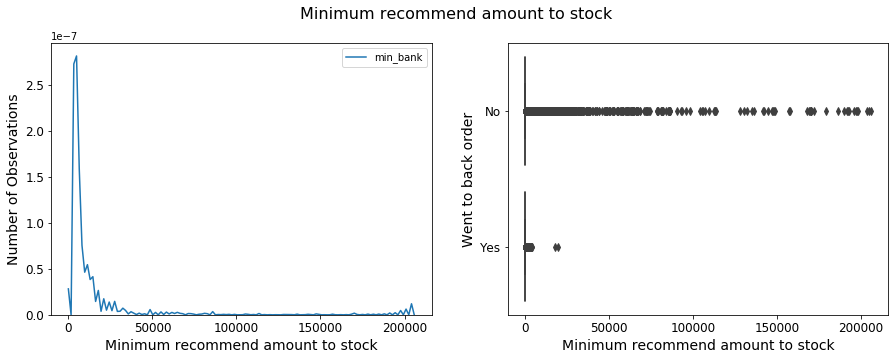

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Minimum recommend amount to stock',fontsize=16)
sns.kdeplot(df['min_bank'])
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='min_bank',y='went_on_backorder',data=df)
plt.xlabel('Minimum recommend amount to stock',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is highly right skewed and with high kurtosis.

We can see that the procuts that went to back orders had most of the observations with 0 as minimum recommended stock. Which means if the recommened stock was higher then the product might not have gone into back order. There are points where the recommended stocks were higher than 0 but still went into back order. This may be due to a sudden rise in the demand of the particular product.

### 12. pieces_past_due

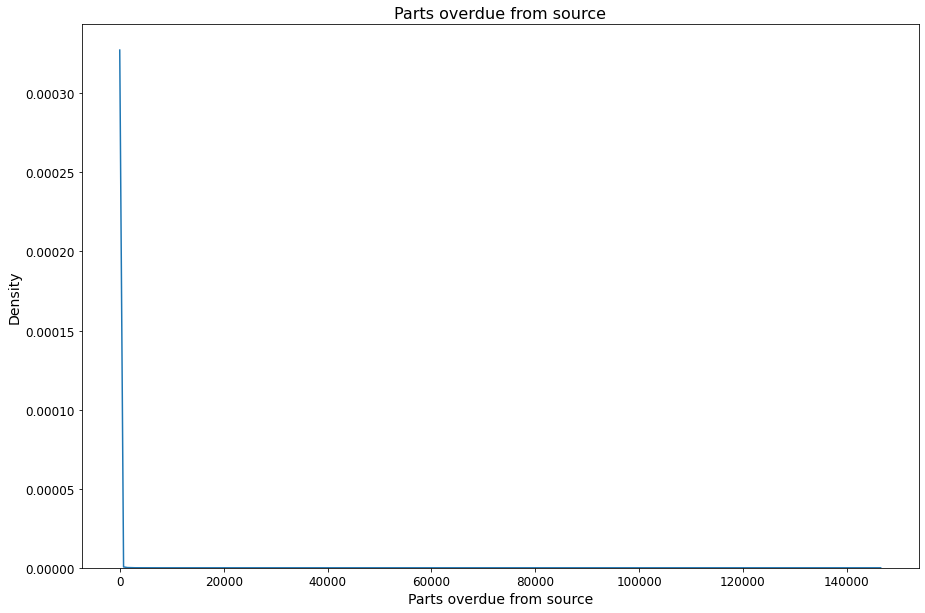

In [83]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['pieces_past_due'])
plt.title('Parts overdue from source',fontsize=16)
plt.xlabel('Parts overdue from source',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

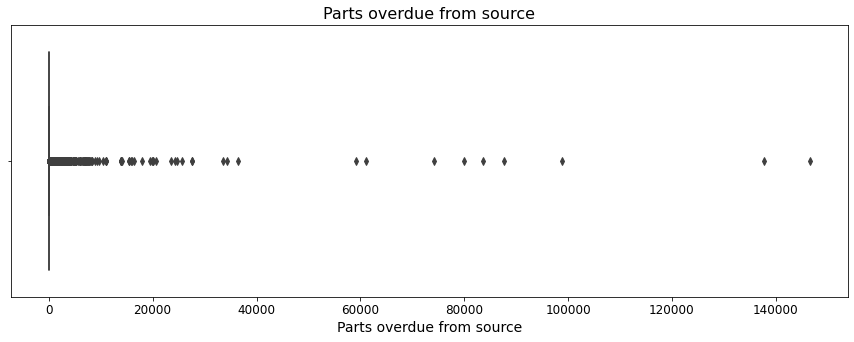

In [84]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['pieces_past_due'])
plt.title('Parts overdue from source',fontsize=16)
plt.xlabel('Parts overdue from source',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [85]:
print('Variance = ',df['pieces_past_due'].var())
print('Skewness =',df['pieces_past_due'].skew())
print('Kurtosis =',df['pieces_past_due'].kurt())

Variance =  56679.18158939287
Skewness = 401.9451352418871
Kurtosis = 197167.86993927104


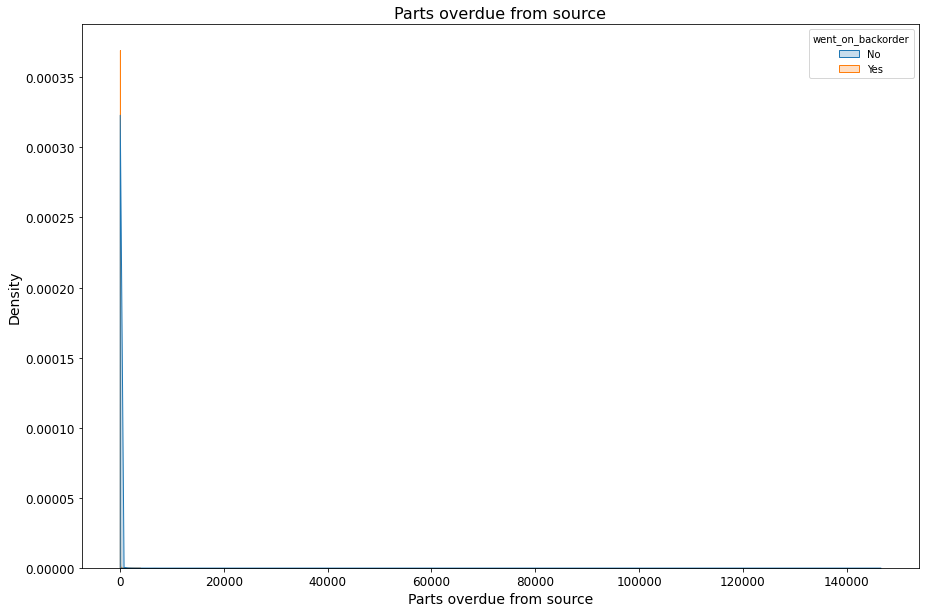

In [86]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='pieces_past_due',hue='went_on_backorder',data=df,fill=True)
plt.title('Parts overdue from source',fontsize=16)
plt.xlabel('Parts overdue from source',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

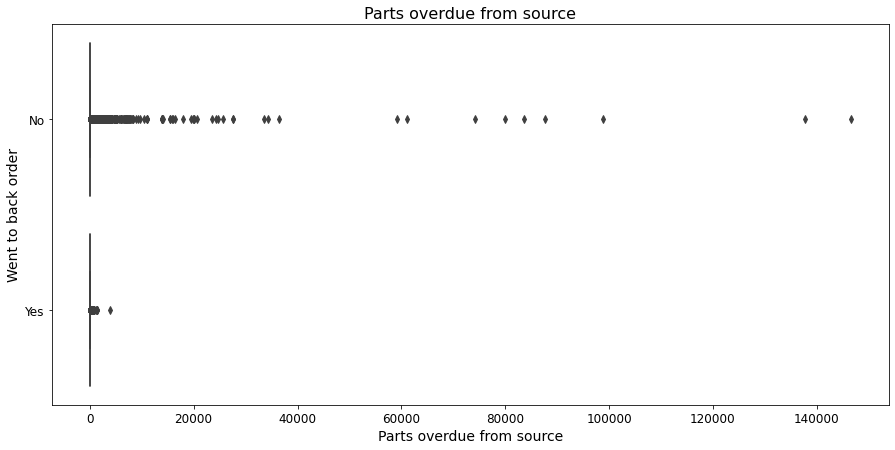

In [87]:
plt.figure(figsize=(15,7))
sns.boxplot(x='pieces_past_due',y='went_on_backorder',data=df)
plt.title('Parts overdue from source',fontsize=16)
plt.xlabel('Parts overdue from source',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

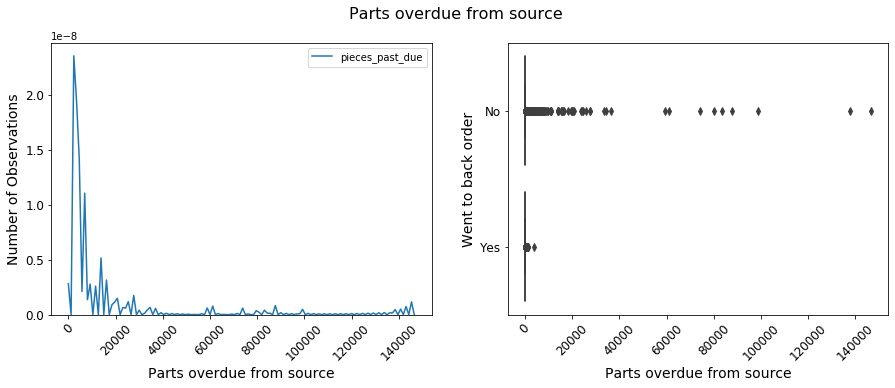

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Parts overdue from source',fontsize=16)
sns.kdeplot(df['pieces_past_due'])
plt.xlabel('Parts overdue from source',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='pieces_past_due',y='went_on_backorder',data=df)
plt.xlabel('Parts overdue from source',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is highly right skewed and has high kurtosis values.

Though we expect to see that the products with pieces past due from the source would go to back order, we see a different pattern here, that is the products that went into back order is more close to 0, ie; the products were not late from the source, while the products that did not go to back order have higher number of outliers with larger dispersion. 

### 13. perf_6_month_avg

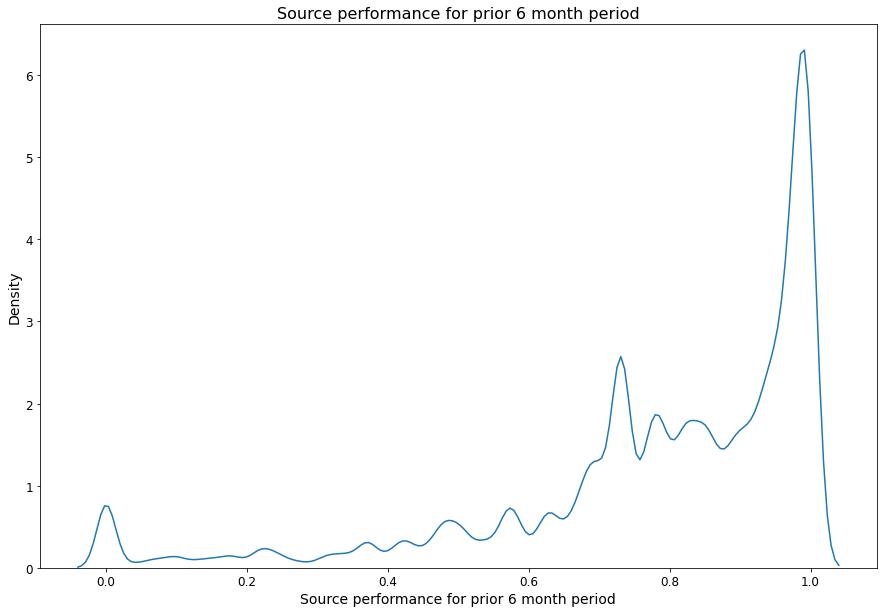

In [88]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['perf_6_month_avg'])
plt.title('Source performance for prior 6 month period',fontsize=16)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

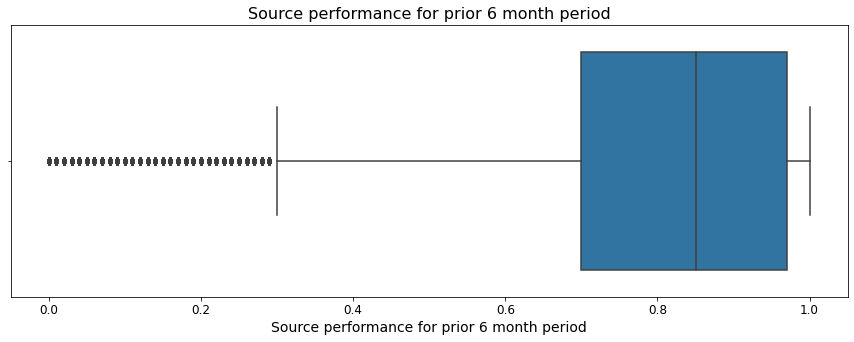

In [89]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['perf_6_month_avg'])
plt.title('Source performance for prior 6 month period',fontsize=16)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [90]:
print('Variance =',df['perf_6_month_avg'].var())
print('Skewness =',df['perf_6_month_avg'].skew())
print('Kurtosis =',df['perf_6_month_avg'].kurt())

Variance = 0.05629859346592042
Skewness = -1.5798562079671874
Kurtosis = 2.2506055264238642


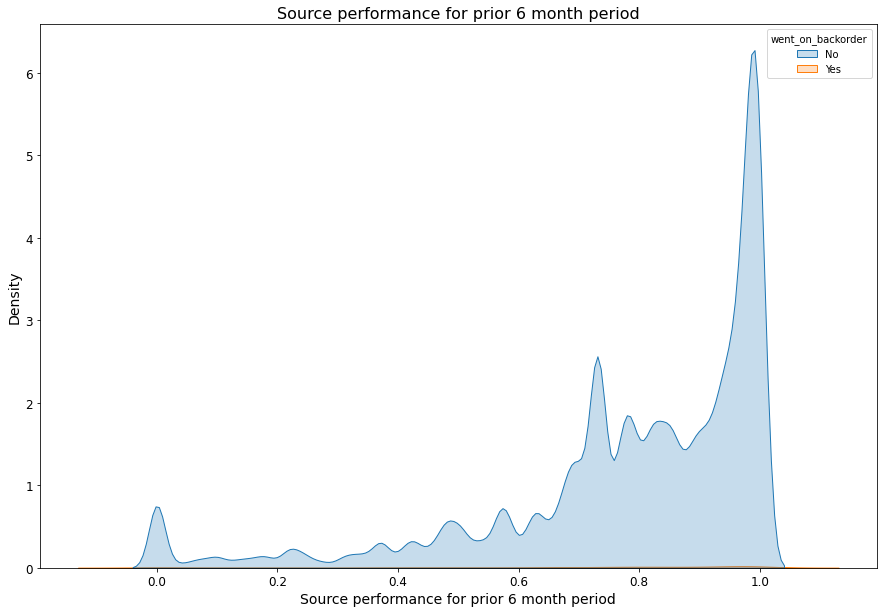

In [91]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='perf_6_month_avg',hue='went_on_backorder',data=df,fill=True)
plt.title('Source performance for prior 6 month period',fontsize=16)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

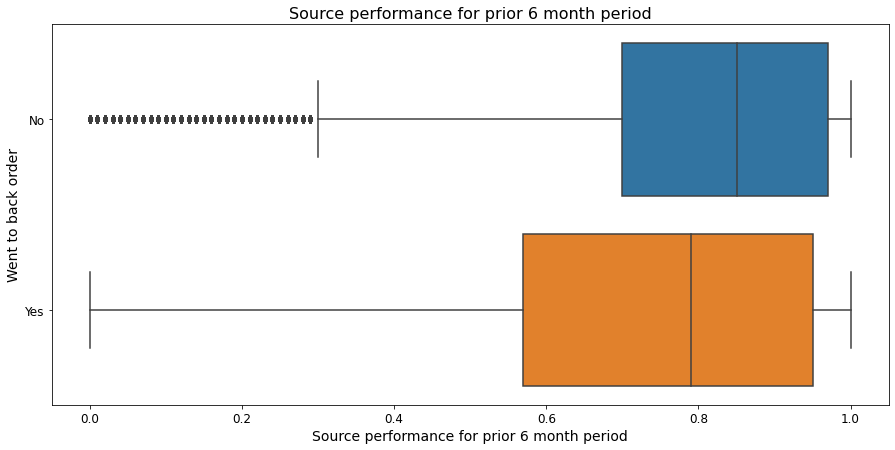

In [92]:
plt.figure(figsize=(15,7))
sns.boxplot(x='perf_6_month_avg',y='went_on_backorder',data=df)
plt.title('Source performance for prior 6 month period',fontsize=16)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

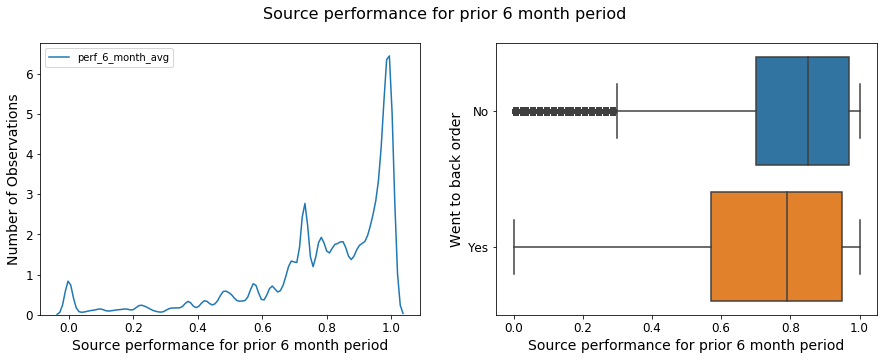

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Source performance for prior 6 month period',fontsize=16)
sns.kdeplot(df['perf_6_month_avg'])
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='perf_6_month_avg',y='went_on_backorder',data=df)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is left skewed and has a kurtosis value of 2.2.

We can see that No category has all the outliers and yes category has no outliers at all.

### 14. perf_12_month_avg

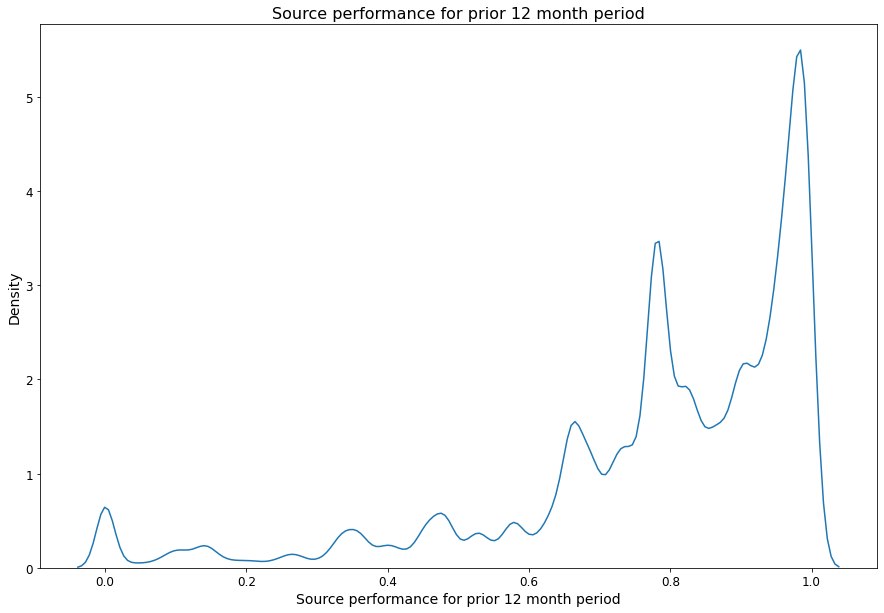

In [93]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['perf_12_month_avg'])
plt.title('Source performance for prior 12 month period',fontsize=16)
plt.xlabel('Source performance for prior 12 month period',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

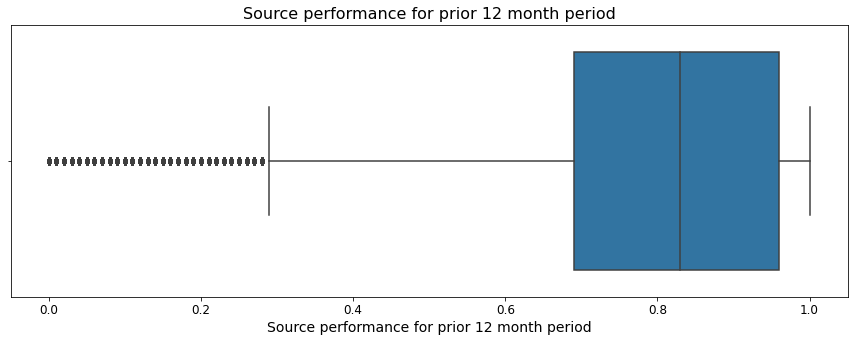

In [94]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['perf_12_month_avg'])
plt.title('Source performance for prior 12 month period',fontsize=16)
plt.xlabel('Source performance for prior 12 month period',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [95]:
print('Variance =',df['perf_12_month_avg'].var())
print('Skewness =',df['perf_12_month_avg'].skew())
print('Kurtosis =',df['perf_12_month_avg'].kurt())

Variance = 0.052088465994965125
Skewness = -1.6191057240321245
Kurtosis = 2.452249999950418


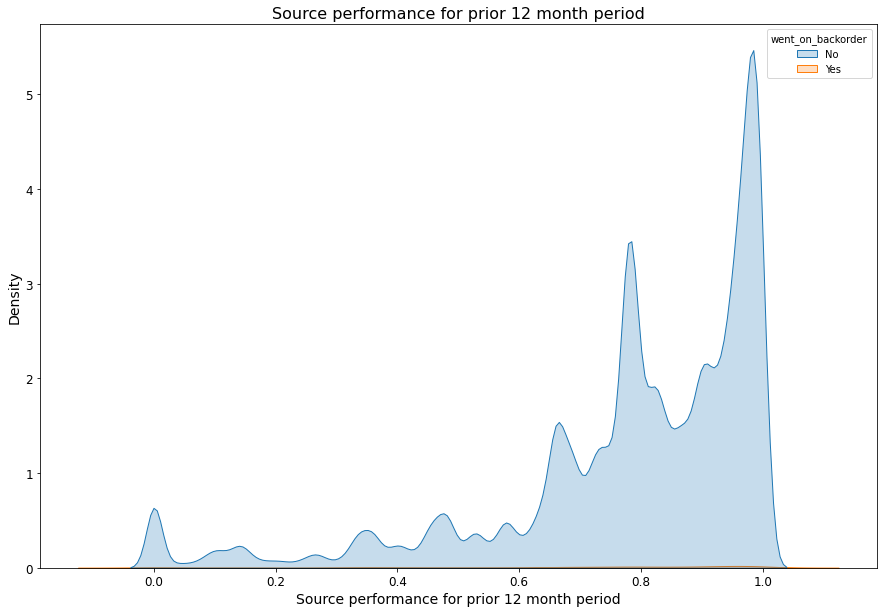

In [96]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='perf_12_month_avg',hue='went_on_backorder',data=df,fill=True)
plt.title('Source performance for prior 12 month period',fontsize=16)
plt.xlabel('Source performance for prior 12 month period',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

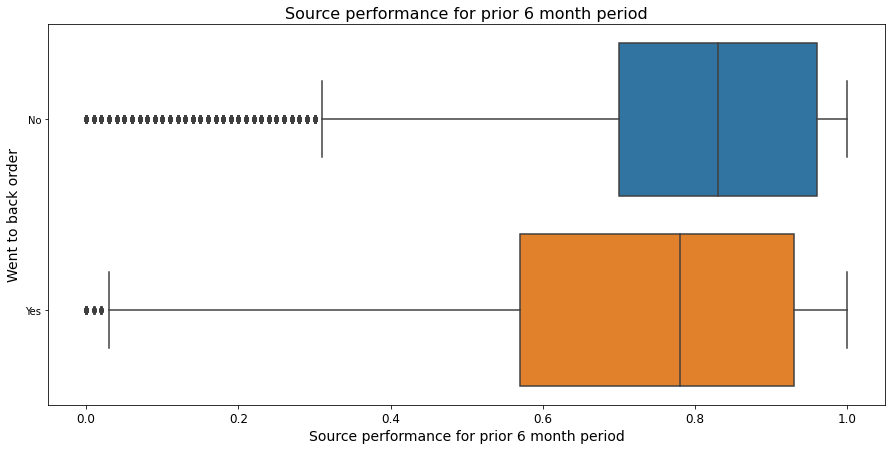

In [97]:
plt.figure(figsize=(15,7))
sns.boxplot(x='perf_12_month_avg',y='went_on_backorder',data=df)
plt.title('Source performance for prior 6 month period',fontsize=16)
plt.xlabel('Source performance for prior 6 month period',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

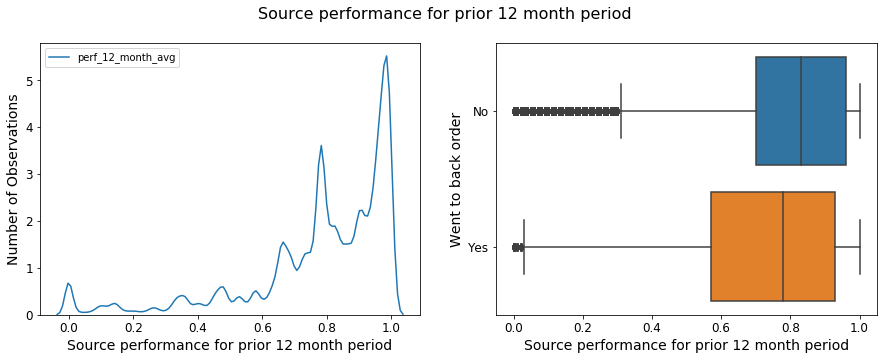

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Source performance for prior 12 month period',fontsize=16)
sns.kdeplot(df['perf_12_month_avg'])
plt.xlabel('Source performance for prior 12 month period',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='perf_12_month_avg',y='went_on_backorder',data=df)
plt.xlabel('Source performance for prior 12 month period',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is left skewed and has a kurtosis value of 2.4.

We can see that No category has maximum outliers and yes category has very few outliers.

### 15. local_bo_qty

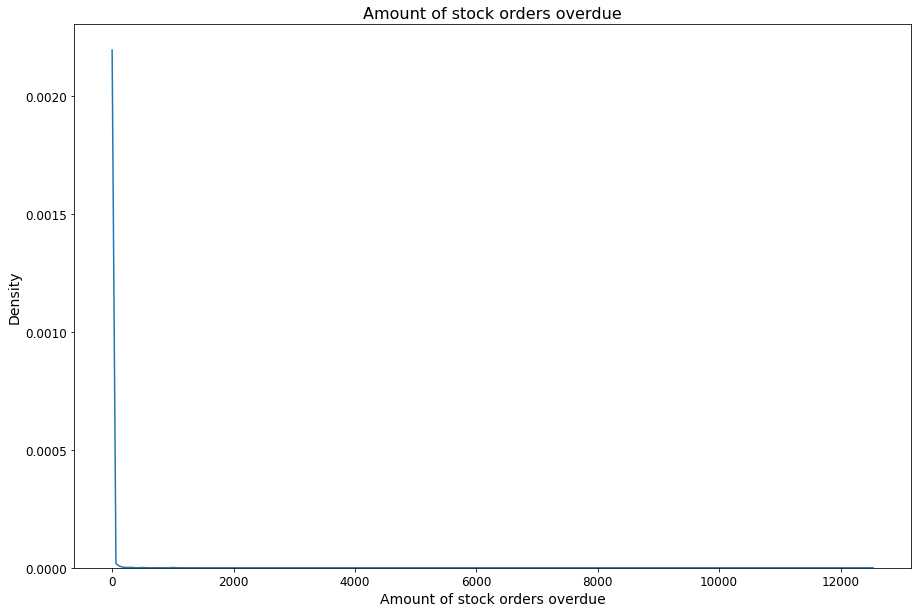

In [98]:
plt.figure(figsize=(15,10))
sns.kdeplot(df['local_bo_qty'])
plt.title('Amount of stock orders overdue',fontsize=16)
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

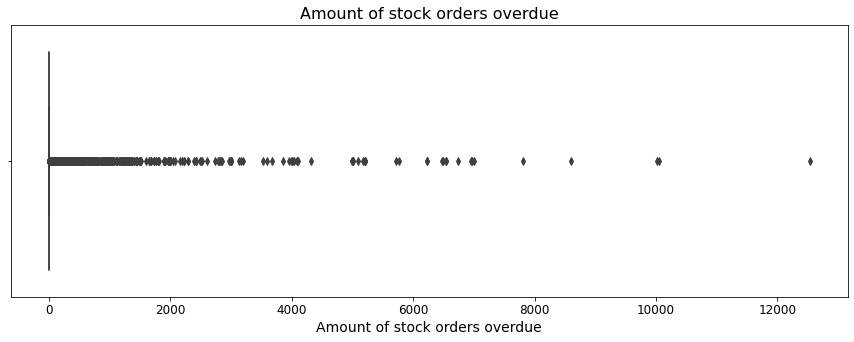

In [99]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['local_bo_qty'])
plt.title('Amount of stock orders overdue',fontsize=16)
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [100]:
print('Variance =',df['local_bo_qty'].var())
print('Skewness =',df['local_bo_qty'].skew())
print('Kurtosis =',df['local_bo_qty'].kurt())

Variance = 1258.4954429167872
Skewness = 150.9431594980128
Kurtosis = 31677.441001663152


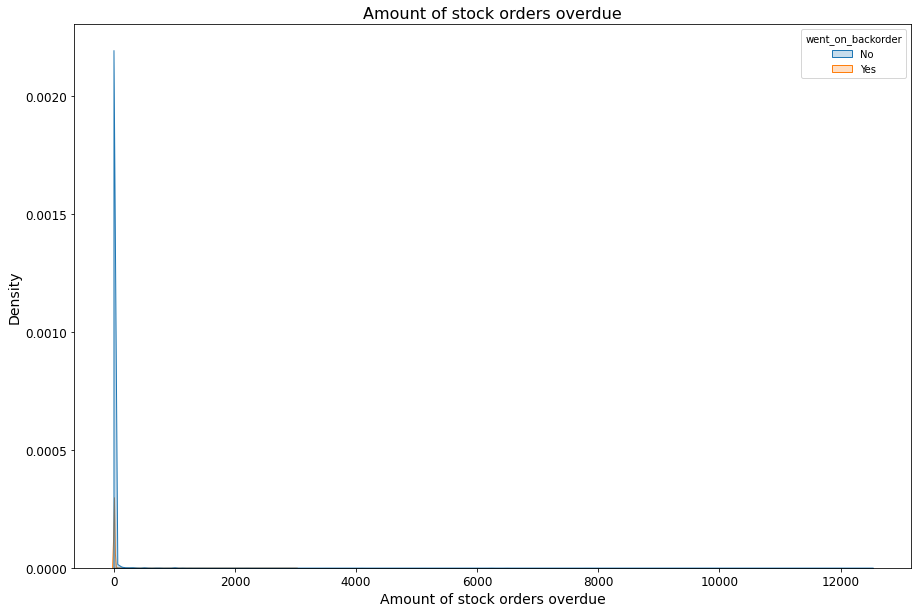

In [101]:
plt.figure(figsize=(15,10))
sns.kdeplot(x='local_bo_qty',hue='went_on_backorder',data=df,fill=True)
plt.title('Amount of stock orders overdue',fontsize=16)
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

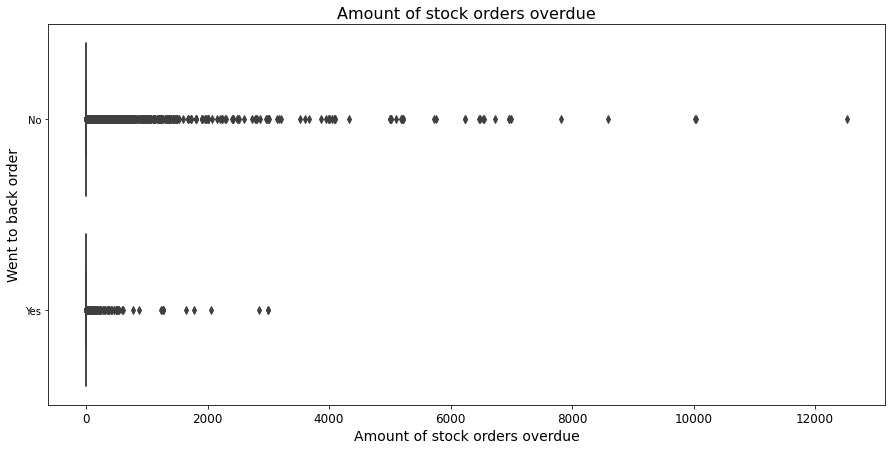

In [102]:
plt.figure(figsize=(15,7))
sns.boxplot(x='local_bo_qty',y='went_on_backorder',data=df)
plt.title('Amount of stock orders overdue',fontsize=16)
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

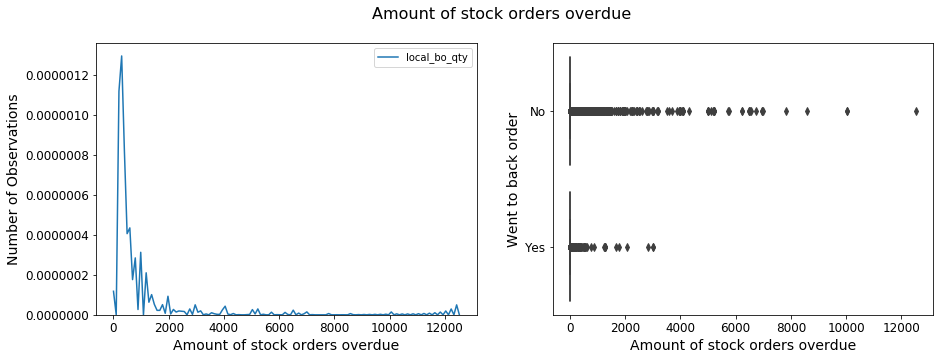

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Amount of stock orders overdue',fontsize=16)
sns.kdeplot(df['local_bo_qty'])
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.ylabel('Number of Observations',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(x='local_bo_qty',y='went_on_backorder',data=df)
plt.xlabel('Amount of stock orders overdue',fontsize=14)
plt.ylabel('Went to back order',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The data is highly right skewed and have high kurtosis.

We can observe that in both the catergories most records are located near 0. There are outliers present in both the classes. The outliers for the No class of the target variable are more dispersed.

## Categorical Variables

In [103]:
print('The categorical columns in the dataset are as follow:\n',list(df.select_dtypes(include='object').columns))

The categorical columns in the dataset are as follow:
 ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


### 1. Potential Issues

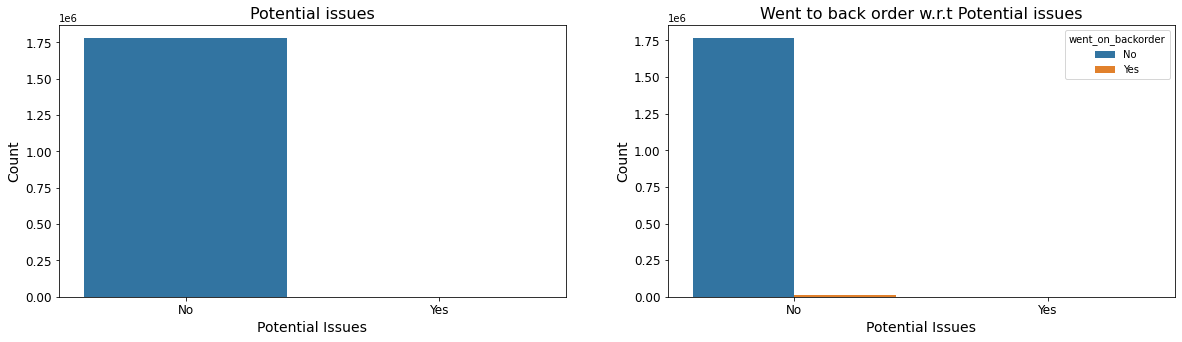

went_on_backorder,No,Yes
potential_issue,,
No,1767022,13373
Yes,907,54


In [104]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='potential_issue',data=df)
plt.title('Potential issues',fontsize=16)
plt.xlabel('Potential Issues',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='potential_issue',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t Potential issues',fontsize=16)
plt.xlabel('Potential Issues',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['potential_issue'],df['went_on_backorder'])

In [105]:
pd.DataFrame(df['potential_issue'].value_counts())

,potential_issue
No,1780395
Yes,961


### 2. Deck RIsk

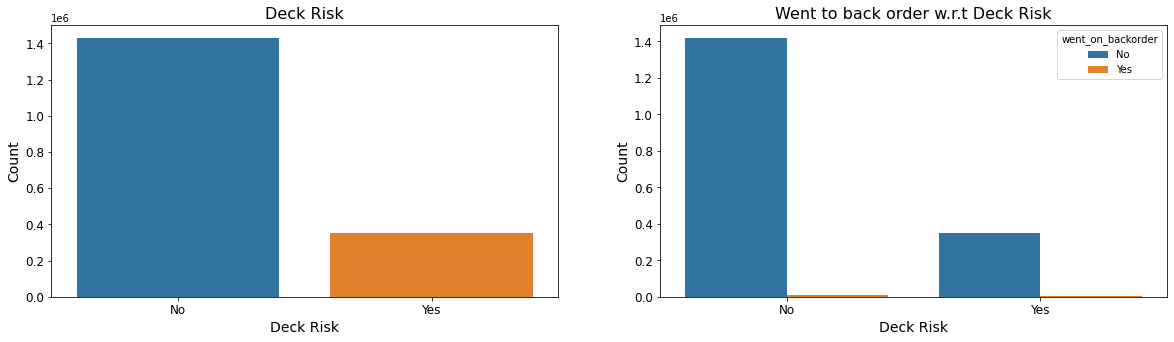

went_on_backorder,No,Yes
deck_risk,,
No,1418654,11269
Yes,349275,2158


In [106]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='deck_risk',data=df)
plt.title('Deck Risk',fontsize=16)
plt.xlabel('Deck Risk',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='deck_risk',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t Deck Risk',fontsize=16)
plt.xlabel('Deck Risk',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['deck_risk'],df['went_on_backorder'])

In [107]:
pd.DataFrame(df['deck_risk'].value_counts())

,deck_risk
No,1429923
Yes,351433


### 3. OE Constraint

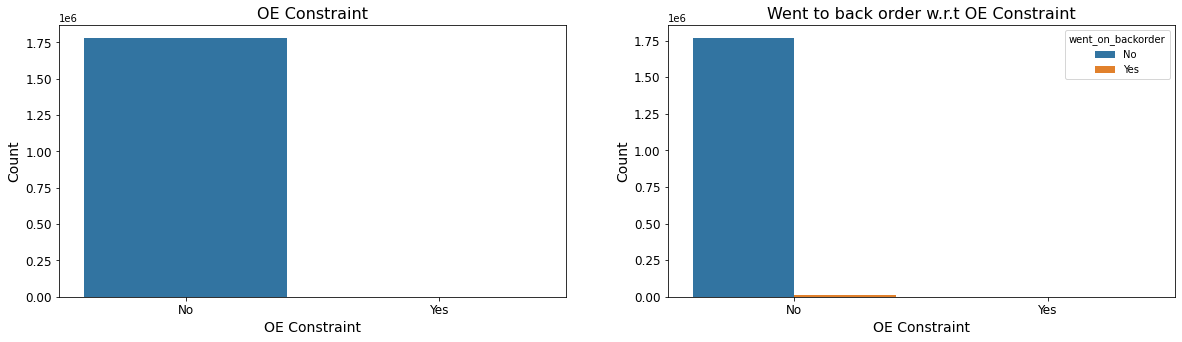

went_on_backorder,No,Yes
oe_constraint,,
No,1767646,13418
Yes,283,9


In [108]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='oe_constraint',data=df)
plt.title('OE Constraint',fontsize=16)
plt.xlabel('OE Constraint',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='oe_constraint',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t OE Constraint',fontsize=16)
plt.xlabel('OE Constraint',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['oe_constraint'],df['went_on_backorder'])

In [109]:
pd.DataFrame(df['oe_constraint'].value_counts())

,oe_constraint
No,1781064
Yes,292


### 4. PPAP Risk

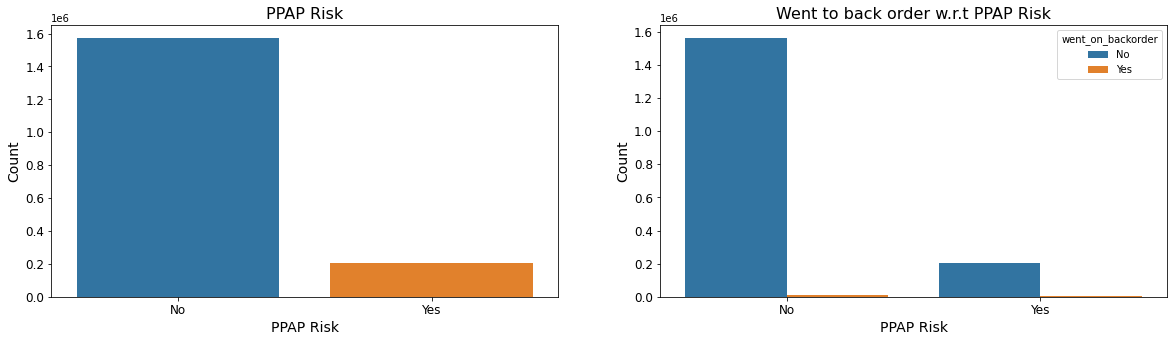

went_on_backorder,No,Yes
ppap_risk,,
No,1561798,11390
Yes,206131,2037


In [110]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='ppap_risk',data=df)
plt.title('PPAP Risk',fontsize=16)
plt.xlabel('PPAP Risk',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='ppap_risk',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t PPAP Risk',fontsize=16)
plt.xlabel('PPAP Risk',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['ppap_risk'],df['went_on_backorder'])

In [111]:
pd.DataFrame(df['ppap_risk'].value_counts())

,ppap_risk
No,1573188
Yes,208168


### 5. Stop Auto Buy

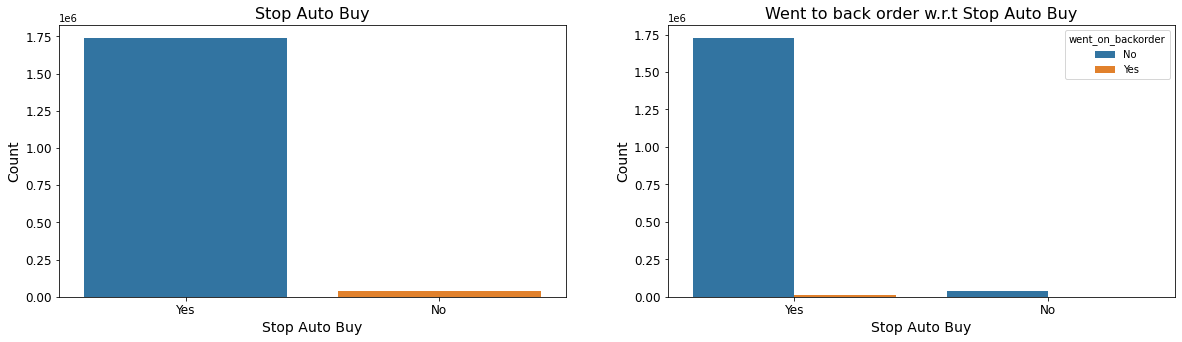

went_on_backorder,No,Yes
stop_auto_buy,,
No,40791,382
Yes,1727138,13045


In [112]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='stop_auto_buy',data=df)
plt.title('Stop Auto Buy',fontsize=16)
plt.xlabel('Stop Auto Buy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='stop_auto_buy',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t Stop Auto Buy',fontsize=16)
plt.xlabel('Stop Auto Buy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['stop_auto_buy'],df['went_on_backorder'])

In [113]:
pd.DataFrame(df['stop_auto_buy'].value_counts())

,stop_auto_buy
Yes,1740183
No,41173


### 6. Rev Stop

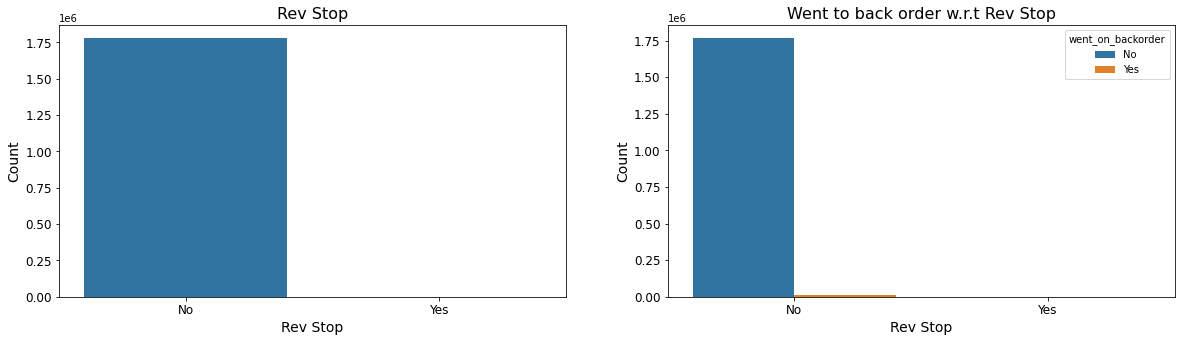

went_on_backorder,No,Yes
rev_stop,,
No,1767511,13423
Yes,418,4


In [114]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='rev_stop',data=df)
plt.title('Rev Stop',fontsize=16)
plt.xlabel('Rev Stop',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
sns.countplot(x='rev_stop',hue='went_on_backorder',data=df)
plt.title('Went to back order w.r.t Rev Stop',fontsize=16)
plt.xlabel('Rev Stop',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

pd.crosstab(df['rev_stop'],df['went_on_backorder'])

In [115]:
pd.DataFrame(df['rev_stop'].value_counts())

,rev_stop
No,1780934
Yes,422


<Figure size 1080x576 with 0 Axes>

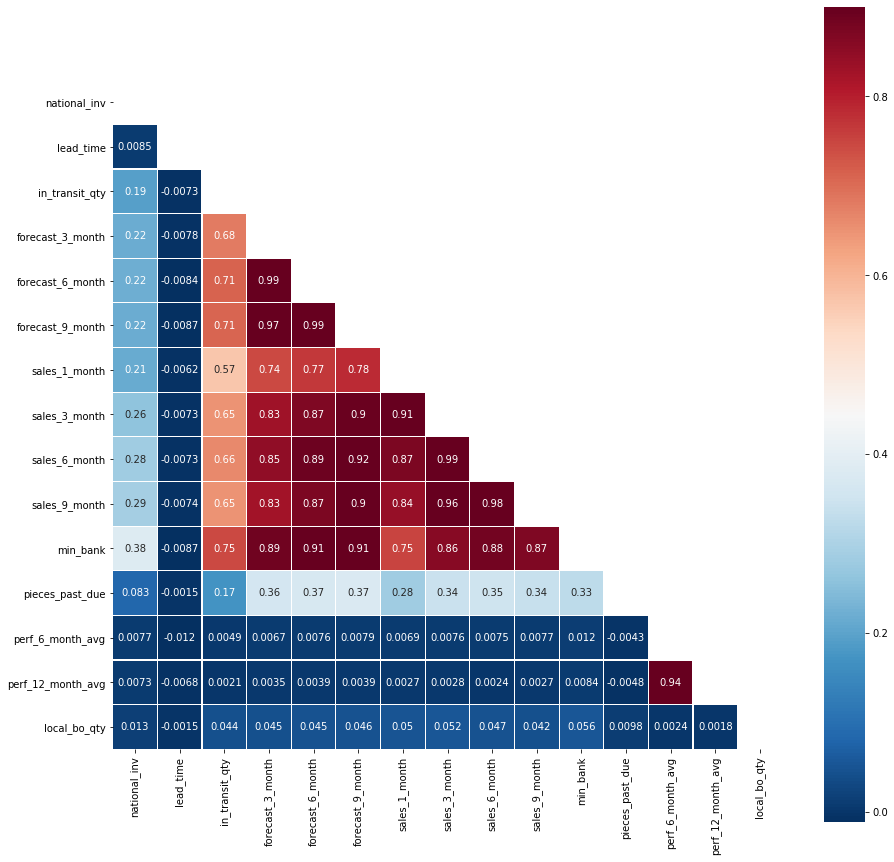

In [25]:
plt.figure(figsize=(15,8))
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=1
fig,ax= plt.subplots()
fig.set_size_inches(15,15)

sns.heatmap(df.corr(),annot=True,mask=mask,square=True,linewidths=0.1,linecolor='white',vmax = .9,cmap = 'RdBu_r')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Considering a sample of 5% from the original data

In [15]:
sample = df.sample(frac=0.05,random_state=1)

In [16]:
sample.shape

(89068, 22)

In [17]:
sample['went_on_backorder'].value_counts()

No     88356
Yes      712
Name: went_on_backorder, dtype: int64

In [18]:
sample['went_on_backorder'].value_counts(normalize=True)*100

No     99.200611
Yes     0.799389
Name: went_on_backorder, dtype: float64

Target variable distribution is almost same as of that of original dataset target variable

## Statistical test to check if the sample represents the Original data

In [121]:
from scipy.stats import ttest_ind,mannwhitneyu
from scipy.stats import jarque_bera
from statsmodels.stats.proportion import proportions_ztest

Hypothesis for Jarque Bera

    H0: The data is normally distributed
    HA: The data is not normally distributed.
    
If data is not normally distributed then mannwhitneyu:
    
    H0: The sample mean is same as df mean.
    HA: The sample mean is not same as df mean.
    
If data is normally distributed then ttest_ind:
    
    H0: The sample mean is same as df mean.
    HA: The sample mean is not same as df mean.

In [122]:
for i in df.select_dtypes(include=np.number):
    t1,p1 = jarque_bera(sample[i])
    t2,p2 = jarque_bera(df[i])
    if p1<0.05 or p2<0.05:
        t3,p3 = mannwhitneyu(sample[i],df[i])
        if p3<0.05:
            print('Mean',i,'is not same for sample and df')
        else:
            print('Mean',i,'is same for sample and df')
    else:
        t4,p4 = ttest_ind(sample[i],df[i])
        if p4<0.05:
            print('Mean',i,'is not same for sample and df')
        else:
            print('Mean',i,'is same for sample and df')
        

Mean national_inv is same for sample and df
Mean lead_time is same for sample and df
Mean in_transit_qty is same for sample and df
Mean forecast_3_month is same for sample and df
Mean forecast_6_month is same for sample and df
Mean forecast_9_month is same for sample and df
Mean sales_1_month is same for sample and df
Mean sales_3_month is same for sample and df
Mean sales_6_month is same for sample and df
Mean sales_9_month is same for sample and df
Mean min_bank is same for sample and df
Mean pieces_past_due is same for sample and df
Mean perf_6_month_avg is same for sample and df
Mean perf_12_month_avg is same for sample and df
Mean local_bo_qty is same for sample and df


All the numerical columns from sample are maintaining the same pattern or distribution like the whole original data(df)

In [123]:
print('H0: The proportion is same')
print('HA: The proportion is not same\n')
for i in df.select_dtypes(include='object'):
    sa = dict(sample[i].value_counts())
    po = dict(df[i].value_counts())
    x = [sa['Yes'],po['Yes']]
    n = [sa['Yes']+sa['No'],po['Yes']+po['No']]
    t,p = proportions_ztest(x,n)
    if p<0.05:
        print('Reject H0, proportion of',i,'in sample is not statistically same as proportion of',i,'in population\n')
    else:
        print('Accept H0, proportion of',i,'in sample is statistically same as proportion of',i,'in population\n')
    

H0: The proportion is same
HA: The proportion is not same

Accept H0, proportion of potential_issue in sample is statistically same as proportion of potential_issue in population

Accept H0, proportion of deck_risk in sample is statistically same as proportion of deck_risk in population

Accept H0, proportion of oe_constraint in sample is statistically same as proportion of oe_constraint in population

Accept H0, proportion of ppap_risk in sample is statistically same as proportion of ppap_risk in population

Accept H0, proportion of stop_auto_buy in sample is statistically same as proportion of stop_auto_buy in population

Accept H0, proportion of rev_stop in sample is statistically same as proportion of rev_stop in population

Accept H0, proportion of went_on_backorder in sample is statistically same as proportion of went_on_backorder in population



### Conclusion:
From above we have proved that the sample is a perfect representation of the population.

In [92]:
sample.shape

(89068, 22)

In [30]:
# changing the target column classes to numerical(Yes:1, No:0) before model building.
sample['went_on_backorder'] = sample['went_on_backorder'].replace({'Yes':1,'No':0})

# Splitting the data into x and y
y=sample['went_on_backorder']
x=sample.drop('went_on_backorder',axis=1)

# Creating dummies on the independent categorical columns
x1=pd.get_dummies(x,drop_first=True)
x1.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
1094229,21.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.84,0.82,0.0,0,1,0,0,1,0
386073,3.0,2.0,1.0,0.0,0.0,0.0,3.0,5.0,5.0,5.0,...,0.0,0.99,0.99,0.0,0,1,0,0,1,0
1546535,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.87,0.88,0.0,0,0,0,1,1,0
19757,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.91,0.74,0.0,0,0,0,0,1,0
1564658,114.0,2.0,92.0,136.0,296.0,439.0,40.0,153.0,304.0,444.0,...,3.0,0.37,0.33,0.0,0,0,0,0,1,0


<Figure size 1080x576 with 0 Axes>

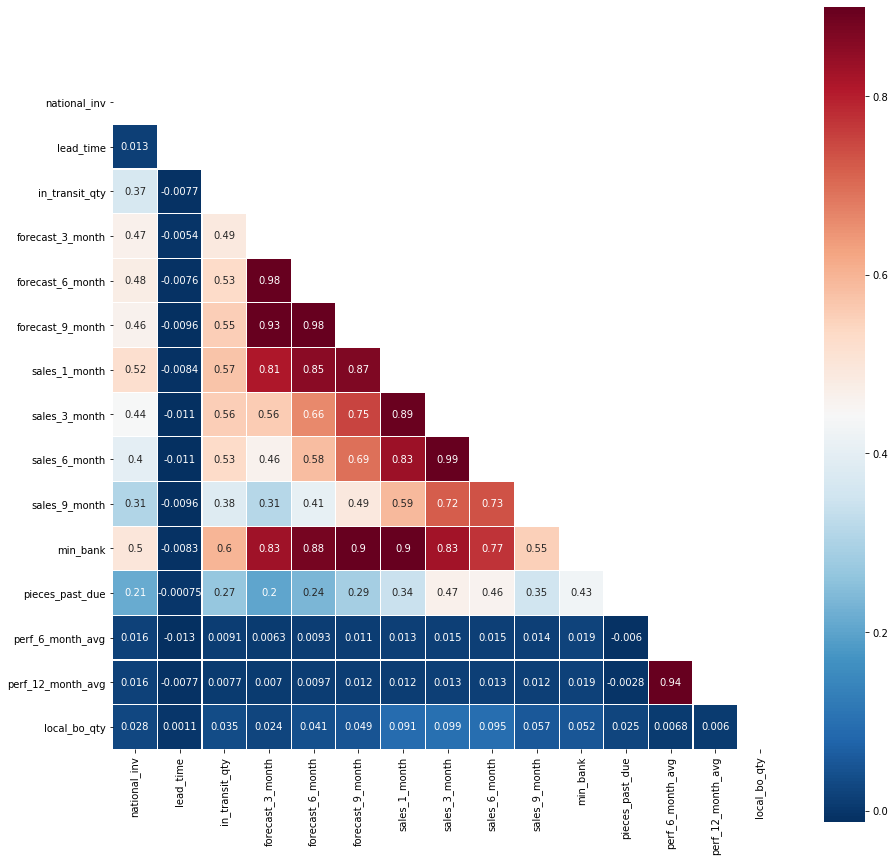

In [26]:
# checking the correlation between all numerical variables

plt.figure(figsize=(15,8))
mask=np.zeros_like(sample.corr())
mask[np.triu_indices_from(mask)]=1
fig,ax= plt.subplots()
fig.set_size_inches(15,15)

sns.heatmap(sample.corr(),annot=True,mask=mask,square=True,linewidths=0.1,linecolor='white',vmax = .9,cmap = 'RdBu_r')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()